In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange,tqdm
import argparse
import xlrd
from datetime import datetime,timedelta
import dateparser
import re
import vcf

In [2]:
import scipy.stats as stats

In [3]:
pd.set_option('display.max_columns',None)

In [4]:
def getloclist(wd,end,filter_out):
    loc_list = []
    EIRA_found = False
    for root, dirs, files in os.walk(wd):
        for file in files:
            if file.endswith(end) and not file.endswith(filter_out):
                loc = os.path.join(root, file)
                loc_list.append(loc) #get bim file location
#     if EIRA_found == True:""
#         print("EIRA detected!")
#     else:
#         print("Warning! No EIRA bim detected! Use first scanned cohort as ref!")
    return loc_list

In [5]:
def openfile(file,n=0,sep=','):
    if file.endswith((".csv",".CSV")):
        clinical = pd.read_csv(file,sep=sep,skiprows=n)
    elif file.endswith((".xlsx",".xls")):
        clinical = pd.read_excel(file,skiprows=n)
    elif file.endswith(".dta"):
        clinical = pd.read_stata(file)
    else:
#         raise ValueError("no clinical file detected!")
        clinical = pd.DataFrame()
    return clinical
def search(columns,patterns=["sjc","crp","sdai","cdai","mtx","Methotrexate"]):
    list_found = []
    for i in trange(len(columns)):
        for j in patterns:
            if j.lower() in columns[i].lower():
                print("Found pattern",j ,"in column num",i,columns[i])
                list_found.append(columns[i])
    return list_found
def search_folder(loc):
    list_found = []
    for root, dirs, files in os.walk(loc):
        for file in files:
            path = os.path.join(root, file)
            opened = openfile(path)
            print("openning file ",file)
            list_found.append(search(opened.columns))
    return list_found

In [6]:
def todatetime(a):
    b = dateparser.parse(a)
#     b = datetime.strptime(b,"%d-%b-%y")
    return b

In [7]:
def countRemission(fam):
    count_case = len(fam[fam[5]==2])
    count_control = len(fam[fam[5]==1])
    count_miss = len(fam[fam[5]==-9])+len(fam[fam[5]==0])
    plt.bar(["case",'control','missing'],[count_case,count_control,count_miss])
    return count_case,count_control,count_miss

In [14]:
# prepare for gwas with MTX as outcomes, get MTX sample subgroup
cohorts = ['EA127genotypes_merged','EARTH_setB_merged','madrid_merged','RAMS_merged','vienna_merged','sera_merged']
loc_list = getloclist("./Pipelinerun_withPC/",".fam",("_A1corr.fam","_noDup.fam","_MTX.fam"))
loc_list_MTX = []
for i in cohorts:
    for j in loc_list:
        if "/"+i in j: #PEAC has EAC inside
            loc_list_MTX.append(j)
            print("found cohort: ",i) 
print(loc_list_MTX)

found cohort:  EA127genotypes_merged
found cohort:  EARTH_setB_merged
found cohort:  madrid_merged
found cohort:  RAMS_merged
found cohort:  RAMS_merged
found cohort:  vienna_merged
found cohort:  sera_merged
['./Pipelinerun_withPC/EARTH_A/mergedChr/EA127genotypes_merged.fam', './Pipelinerun_withPC/EARTH_B/mergedChr/EARTH_setB_merged.fam', './Pipelinerun_withPC/Madrid/mergedChr/madrid_merged.fam', './Pipelinerun_withPC/RAMS/mergedChr/RAMS_merged.fam', './Pipelinerun_withPC/TwoCompDAS/RAMS_merged_2cDAS.fam', './Pipelinerun_withPC/Vienna/mergedChr/vienna_merged.fam', './Pipelinerun_withPC/SERA/mergedChr/sera_merged.fam']


## EARTH_setA

In [30]:
EarthA = openfile("/exports/reum/knevel_lab/EARTH/SetA/clinical/GWAS_Remission_23082019_V3_Shared_adj.csv",n=1,sep=';')
EarthA = EarthA.fillna("notAvailable")

In [31]:
search(EarthA.columns,patterns=['ccp'])

100%|███████████████████████████████████████| 90/90 [00:00<00:00, 372275.50it/s]

Found pattern ccp in column num 16 CCP Status
Found pattern ccp in column num 17 CCP


['CCP Status', 'CCP']

In [32]:
EarthA_fam = pd.read_csv("/exports/reum/CKe/Pipelinerun_withPC/EARTH_A/mergedChr/EA127genotypes_merged.fam",sep='\s',header=None)
EarthA_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,EA0131_EA0131,EA0131_EA0131,0,0,0,-9
1,EA0142_EA0142,EA0142_EA0142,0,0,0,-9
2,EA0184_EA0184,EA0184_EA0184,0,0,0,-9
3,EA0196_EA0196,EA0196_EA0196,0,0,0,-9
4,EA0203_EA0203,EA0203_EA0203,0,0,0,-9
...,...,...,...,...,...,...
122,EA2744_EA2744,EA2744_EA2744,0,0,0,2
123,EA2745_EA2745,EA2745_EA2745,0,0,0,1
124,EA2759_EA2759,EA2759_EA2759,0,0,0,2
125,EA2767_EA2767,EA2767_EA2767,0,0,0,1


In [33]:
EarthA

,DMARD after inclusion,double,RA,2,Source,EA Number,OldEAC_1stDMARD_Date,EAC seen date,Earliest Date,Months since 1st Visit,Between 4 and 18 months,Sex,Age at EAC,HAQ,RF Status,RF Titre,CCP Status,CCP,BL_DMARDS,BL_Steroid,EMS,Symptom duration at EAC (weeks),GlobalVAS,Tender28,Swollen28,ESR,CRP,DAS28,DAS28_CRP,1st cons diag,Working diagnosis latest visit / on discharge,Cigarrettes,Smoking,Smoking Status,Cigarette Pack-Yrs,Alcohol,OldEAC_1stDMARD,OldEAC_1stDMARD_Date.1,OldEAC_2ndDMARD,OldEAC_2ndDMARD_Date,OldEAC_MTX_Duration,OldEAC_MTX_Stopped,Start Abatacept,End Abatacept,Start Abatacept S/C,End Abatacept S/C,Start Abatacept SC,End Abatacept SC,Start Adalimumab,End Adalimumab,Start Adalimumab SC,End Adalimumab SC,Start Baricitinib,End Baricitinib,Start Certolizumab,End Certolizumab,Etanercept,Etanercept SC,Start Folic acid,End Folic acid,Golimumab,Hydroxychloroquine,Infliximab,Start Leflunomide,End Leflunomide,Start Methotrexate PO,End Methotrexate PO,Start Methotrexate SC,End Methotrexate SC,Start Rituximab,End Rituximab,Start Secukinumab,End Secukinumab,Start Steroid IA,End Steroid IA,Start Steroid IM,End Steroid IM,Start Steroid PO,End Steroid PO,Start Sulphasalazine,End Sulphasalazine,Start Tocilizumab,End Tocilizumab,Start Tocilizumab IV,End Tocilizumab IV,Start Tocilizumab S/C,End Tocilizumab S/C,Start Tocilizumab SC,End Tocilizumab SC,Tofacitinib
0,1.0,0,1,3,OldEarth,131,19/04/2007,19-Oct-06,19-okt-06,"0,00","0,00",F,47,"1,25",Negative,0.0,Negative,0.0,notAvailable,notAvailable,240,10.0,30.0,15.0,3.0,18.0,10.0,notAvailable,"4,90",UA,RA,notAvailable,,Never,notAvailable,notAvailable,SZP,19/04/2007,MTX,23/08/2008,ongoing,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,25-mrt-10,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable
1,1.0,0,1,6,OldEarth,142,21/12/2006,6-Nov-06,06-nov-06,"0,00","0,00",M,59,"1,875",Positive,40.0,Negative,0.0,notAvailable,notAvailable,480,16.0,75.0,15.0,3.0,24.0,15.0,"5,93","5,66",RA,RA,>0,,Past,notAvailable,notAvailable,MTX,21/12/2006,Other,21/12/2006,ongoing,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable
2,1.0,0,1,7,OldEarth,184,15/03/2007,26-Feb-07,26-feb-07,"0,00","0,00",F,79,"1,625",Positive,640.0,Positive,14.0,notAvailable,notAvailable,0,8.0,0.0,5.0,4.0,30.0,9.0,"4,19","0,00",RA,RA,notAvailable,,Never,notAvailable,notAvailable,MTX,15/03/2007,notAvailable,notAvailable,ongoing,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,n

In [35]:
EarthA_ccp = EarthA.drop_duplicates('EA Number',keep='last').loc[:,['EA Number','CCP Status']]
EarthA_ccp

,EA Number,CCP Status
1,142,Negative
2,184,Positive
5,204,Positive
6,247,Positive
7,218,Positive
...,...,...
646,1032,Positive
647,196,notAvailable
648,2042,Negative
649,2744,Positive


In [36]:
EarthA_sample = EarthA_ccp['EA Number'].unique().tolist()
IDlist = []
for i in EarthA_sample:
    if len(str(i))<4:
        trueID = "EA"+"0"+str(i)+"_"+"EA"+"0"+str(i)
        IDlist.append(trueID)
    else:
        trueID = "EA"+str(i)+"_"+"EA"+str(i)
        IDlist.append(trueID)
print(IDlist,len(IDlist))
EarthA_ccp['id'] = IDlist
# EarthA_ccp['id'] = EarthA_ccp['id']+'_'+EarthA_ccp['id']

['EA0142_EA0142', 'EA0184_EA0184', 'EA0204_EA0204', 'EA0247_EA0247', 'EA0218_EA0218', 'EA0221_EA0221', 'EA0232_EA0232', 'EA0239_EA0239', 'EA0254_EA0254', 'EA0261_EA0261', 'EA0264_EA0264', 'EA0273_EA0273', 'EA0296_EA0296', 'EA0294_EA0294', 'EA0302_EA0302', 'EA0306_EA0306', 'EA0315_EA0315', 'EA0322_EA0322', 'EA0336_EA0336', 'EA0350_EA0350', 'EA0358_EA0358', 'EA0364_EA0364', 'EA0366_EA0366', 'EA0369_EA0369', 'EA0378_EA0378', 'EA0388_EA0388', 'EA0389_EA0389', 'EA0397_EA0397', 'EA0401_EA0401', 'EA0439_EA0439', 'EA0253_EA0253', 'EA0220_EA0220', 'EA0305_EA0305', 'EA0203_EA0203', 'EA0820_EA0820', 'EA0907_EA0907', 'EA0932_EA0932', 'EA0957_EA0957', 'EA0930_EA0930', 'EA0946_EA0946', 'EA1005_EA1005', 'EA0997_EA0997', 'EA0968_EA0968', 'EA0975_EA0975', 'EA0854_EA0854', 'EA2154_EA2154', 'EA0938_EA0938', 'EA0915_EA0915', 'EA0978_EA0978', 'EA1042_EA1042', 'EA2090_EA2090', 'EA0844_EA0844', 'EA0840_EA0840', 'EA0810_EA0810', 'EA1086_EA1086', 'EA0995_EA0995', 'EA0892_EA0892', 'EA0827_EA0827', 'EA0882_EA088

In [37]:
EarthA_ccp

,EA Number,CCP Status,id
1,142,Negative,EA0142_EA0142
2,184,Positive,EA0184_EA0184
5,204,Positive,EA0204_EA0204
6,247,Positive,EA0247_EA0247
7,218,Positive,EA0218_EA0218
...,...,...,...
646,1032,Positive,EA1032_EA1032
647,196,notAvailable,EA0196_EA0196
648,2042,Negative,EA2042_EA2042
649,2744,Positive,EA2744_EA2744


In [38]:
EarthA_fam_ccp = pd.merge(EarthA_fam,EarthA_ccp,how='inner',left_on=0,right_on='id')
EarthA_fam_ccp

,0,1,2,3,4,5,EA Number,CCP Status,id
0,EA0131_EA0131,EA0131_EA0131,0,0,0,-9,131,notAvailable,EA0131_EA0131
1,EA0142_EA0142,EA0142_EA0142,0,0,0,-9,142,Negative,EA0142_EA0142
2,EA0184_EA0184,EA0184_EA0184,0,0,0,-9,184,Positive,EA0184_EA0184
3,EA0196_EA0196,EA0196_EA0196,0,0,0,-9,196,notAvailable,EA0196_EA0196
4,EA0203_EA0203,EA0203_EA0203,0,0,0,-9,203,Positive,EA0203_EA0203
...,...,...,...,...,...,...,...,...,...
122,EA2744_EA2744,EA2744_EA2744,0,0,0,2,2744,Positive,EA2744_EA2744
123,EA2745_EA2745,EA2745_EA2745,0,0,0,1,2745,Negative,EA2745_EA2745
124,EA2759_EA2759,EA2759_EA2759,0,0,0,2,2759,Negative,EA2759_EA2759
125,EA2767_EA2767,EA2767_EA2767,0,0,0,1,2767,Negative,EA2767_EA2767


In [39]:
EarthA_fam_ccp['CCP'] = EarthA_fam_ccp['CCP Status'].map({'Negative':1,'Positive':2,'notAvailable':-9})

In [40]:
EarthA_fam_ccp.fillna(-9,inplace=True)

In [42]:
EarthA_fam_ccp['CCP'] = EarthA_fam_ccp['CCP'].astype(int)

In [43]:
EarthA_fam_ccp

,0,1,2,3,4,5,EA Number,CCP Status,id,CCP
0,EA0131_EA0131,EA0131_EA0131,0,0,0,-9,131,notAvailable,EA0131_EA0131,-9
1,EA0142_EA0142,EA0142_EA0142,0,0,0,-9,142,Negative,EA0142_EA0142,1
2,EA0184_EA0184,EA0184_EA0184,0,0,0,-9,184,Positive,EA0184_EA0184,2
3,EA0196_EA0196,EA0196_EA0196,0,0,0,-9,196,notAvailable,EA0196_EA0196,-9
4,EA0203_EA0203,EA0203_EA0203,0,0,0,-9,203,Positive,EA0203_EA0203,2
...,...,...,...,...,...,...,...,...,...,...
122,EA2744_EA2744,EA2744_EA2744,0,0,0,2,2744,Positive,EA2744_EA2744,2
123,EA2745_EA2745,EA2745_EA2745,0,0,0,1,2745,Negative,EA2745_EA2745,1
124,EA2759_EA2759,EA2759_EA2759,0,0,0,2,2759,Negative,EA2759_EA2759,1
125,EA2767_EA2767,EA2767_EA2767,0,0,0,1,2767,Negative,EA2767_EA2767,1


In [44]:
EarthA_fam_ccp.loc[:,[0,1,2,3,4,'CCP']].to_csv("/exports/reum/CKe/Pipelinerun_withPC/CCP_assoc/EA127genotypes_merged_ccp.fam",sep='\t',index=False,header=False)

In [25]:
# def vcftotable(vcf_loc):
vcfEarthA = vcf.Reader(open("/exports/reum/CKe/Pipelinerun_withPC/EARTH_A/mergedChr/EA127genotypes_merged.vcf", 'r'))
for record in vcfEarthA:
    dict_snp = {}
    print("snp: ",record.CHROM+":"+str(record.POS))
    for i in EarthA_ccp['id'].tolist():
        dict_snp1[i]=record.genotype(i)['GT']
    EarthA_ccp['Genotypes_'+record.CHROM+":"+str(record.POS)] = EarthA_ccp['id'].map(dict_snp1)

snp:  2:4117199


KeyError: 'EA0142_EA0142'

In [192]:
EarthA_ccp['CCP Status'] = EarthA_ccp['CCP Status'].map({'Negative':1,'Positive':2})
EarthA_ccp['Genotypes_2:4117199'] = EarthA_ccp['Genotypes_2:4117199'].map({'0/0':1,'0/1':2,'1/1':0})
EarthA_ccp['Genotypes_2:179448911'] = EarthA_ccp['Genotypes_2:179448911'].map({'0/0':1.0,'0/1':2.0,'1/1':0.0})

In [194]:
EarthA_ccp.dropna(inplace=True)

In [223]:
stats.chi2(EarthA_ccp['CCP Status'],EarthA_ccp['Genotypes_2:4117199'])  # 相关系数和P值
# print('Correlation coef r = %6.3f，pval = %6.3f'%(r,p))

In [235]:
stat,p,dof,expected = stats.chi2_contingency([EarthA_ccp['CCP Status'].tolist(),EarthA_ccp['Genotypes_2:4117199'].tolist()]) # stat卡方统计值，p：P_value，dof 自由度，expected理论频率分布
print('dof=%d'%dof)
# print(expected)
prob = 0.95 # 选取95%置信度
critical = stats.chi2.ppf(prob,dof)  # 计算临界阀值
print('probality=%.3f,critical=%.3f,stat=%.3f '%(prob,critical,stat))
if abs(stat)>=critical:
    print('reject H0:Dependent')
else:
    print('fail to reject H0:Independent')

alpha = 1-prob
print('significance=%.3f,p=%.3f'%(alpha,p))
if p<alpha:
    print('reject H0:Dependent')
else:
    print('fail to reject H0:Independent')

dof=117
probality=0.950,critical=143.246,stat=35.582 
fail to reject H0:Independent
significance=0.050,p=1.000
fail to reject H0:Independent


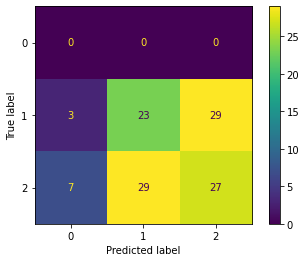

In [220]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(EarthA_ccp['CCP Status'], EarthA_ccp['Genotypes_2:4117199'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [70]:
EarthA['Earliest Date'] = EarthA['Earliest Date'].map(todatetime)
EarthA['Start Methotrexate PO'] = EarthA['Start Methotrexate PO'].map(todatetime)
EarthA['Start Methotrexate SC'] = EarthA['Start Methotrexate SC'].map(todatetime)

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [101]:
EarthA_MTX = EarthA[((EarthA['Start Methotrexate SC'] - EarthA['Earliest Date']) <= timedelta(180)) | (EarthA['Start Methotrexate PO'] - EarthA['Earliest Date'] <=  timedelta(180))]
EarthA_MTX['days_since_MTX_SC'] = EarthA_MTX['Start Methotrexate SC'] - EarthA_MTX['Earliest Date']
EarthA_MTX['days_since_MTX_OP'] = EarthA_MTX['Start Methotrexate PO'] - EarthA_MTX['Earliest Date']
EarthA_MTX

/tmp/ipykernel_2371238/2733279593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EarthA_MTX['days_since_MTX_SC'] = EarthA_MTX['Start Methotrexate SC'] - EarthA_MTX['Earliest Date']
/tmp/ipykernel_2371238/2733279593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EarthA_MTX['days_since_MTX_OP'] = EarthA_MTX['Start Methotrexate PO'] - EarthA_MTX['Earliest Date']


,DMARD after inclusion,double,RA,2,Source,EA Number,OldEAC_1stDMARD_Date,EAC seen date,Earliest Date,Months since 1st Visit,Between 4 and 18 months,Sex,Age at EAC,HAQ,RF Status,RF Titre,CCP Status,CCP,BL_DMARDS,BL_Steroid,EMS,Symptom duration at EAC (weeks),GlobalVAS,Tender28,Swollen28,ESR,CRP,DAS28,DAS28_CRP,1st cons diag,Working diagnosis latest visit / on discharge,Cigarrettes,Smoking,Smoking Status,Cigarette Pack-Yrs,Alcohol,OldEAC_1stDMARD,OldEAC_1stDMARD_Date.1,OldEAC_2ndDMARD,OldEAC_2ndDMARD_Date,OldEAC_MTX_Duration,OldEAC_MTX_Stopped,Start Abatacept,End Abatacept,Start Abatacept S/C,End Abatacept S/C,Start Abatacept SC,End Abatacept SC,Start Adalimumab,End Adalimumab,Start Adalimumab SC,End Adalimumab SC,Start Baricitinib,End Baricitinib,Start Certolizumab,End Certolizumab,Etanercept,Etanercept SC,Start Folic acid,End Folic acid,Golimumab,Hydroxychloroquine,Infliximab,Start Leflunomide,End Leflunomide,Start Methotrexate PO,End Methotrexate PO,Start Methotrexate SC,End Methotrexate SC,Start Rituximab,End Rituximab,Start Secukinumab,End Secukinumab,Start Steroid IA,End Steroid IA,Start Steroid IM,End Steroid IM,Start Steroid PO,End Steroid PO,Start Sulphasalazine,End Sulphasalazine,Start Tocilizumab,End Tocilizumab,Start Tocilizumab IV,End Tocilizumab IV,Start Tocilizumab S/C,End Tocilizumab S/C,Start Tocilizumab SC,End Tocilizumab SC,Tofacitinib,days_since_MTX_SC,days_since_MTX_OP
42,1.0,0,1,49,New Earth EAC,810,notAvailable,22-May-12,2012-05-22,"0,00","0,00",M,56,notAvailable,Positive,130.0,Positive,340.0,0.0,0.0,120,52.0,52.0,13.0,3.0,13.0,7.0,"5,03","4,94",Rheumatoid Arthritis,Rheumatoid Arthritis,notAvailable,,Past,27.0,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,03-jul-12,notAvailable,notAvailable,notAvailable,2012-07-03,23-okt-12,NaT,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,NaT,42 days
44,notAvailable,1,1,59,New Earth EAC,827,notAvailable,26-Jun-12,2012-06-26,"0,00","0,00",F,50,notAvailable,Negative,notAvailable,Negative,2.0,0.0,0.0,60,12.0,46.0,13.0,3.0,7.0,5.0,"4,51","4,75",Rheumatoid Arthritis,Rheumatoid Arthritis,notAvailable,Y,Present,25.0,6.0,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,2012-07-26,31-jan-13,NaT,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,21-sep-12,16-jul-13,26-jun-12,26-jun-12,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,NaT,30 days
45,notAvailable,0,1,60,New Earth EAC,827,notAvailable,26-Jun-12,2012-06-26,"0,00","0,00",F,50,notAvailable,Negative,notAvailable,Negative,2.0,0.0,0.0,notAvailable,12.0,0.0,0.0,0.0,notAvailable,notAvailable,notAvailable,notAvailable,Rheumatoid Arthritis,Rheumatoid Arthritis,notAvailable,Y,Present,25.0,6.0,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAvailable,notAv

In [105]:
EarthA_MTX_sample = EarthA_MTX['EA Number'].unique().tolist()
IDlist = []
for i in EarthA_MTX_sample:
    if len(str(i))<4:
        trueID = "EA"+"0"+str(i)+"_"+"EA"+"0"+str(i)
        IDlist.append(trueID)
    else:
        trueID = "EA"+str(i)+"_"+"EA"+str(i)
        IDlist.append(trueID)
print(IDlist,len(IDlist))

['EA0810_EA0810', 'EA0827_EA0827', 'EA0838_EA0838', 'EA0840_EA0840', 'EA0844_EA0844', 'EA0882_EA0882', 'EA0892_EA0892', 'EA0896_EA0896', 'EA0915_EA0915', 'EA0926_EA0926', 'EA0929_EA0929', 'EA0931_EA0931', 'EA0938_EA0938', 'EA0941_EA0941', 'EA0948_EA0948', 'EA0957_EA0957', 'EA0968_EA0968', 'EA0974_EA0974', 'EA0978_EA0978', 'EA0992_EA0992', 'EA0995_EA0995', 'EA0996_EA0996', 'EA0997_EA0997', 'EA1010_EA1010', 'EA1029_EA1029', 'EA1032_EA1032', 'EA1042_EA1042', 'EA1051_EA1051', 'EA1067_EA1067', 'EA1072_EA1072', 'EA1086_EA1086', 'EA1094_EA1094', 'EA2029_EA2029', 'EA2030_EA2030', 'EA2042_EA2042', 'EA2045_EA2045', 'EA2072_EA2072', 'EA2090_EA2090', 'EA2106_EA2106', 'EA2110_EA2110', 'EA2133_EA2133', 'EA2138_EA2138', 'EA2166_EA2166', 'EA2184_EA2184', 'EA2203_EA2203', 'EA2206_EA2206', 'EA2215_EA2215', 'EA2231_EA2231', 'EA2255_EA2255', 'EA2294_EA2294', 'EA2300_EA2300', 'EA2310_EA2310', 'EA2311_EA2311', 'EA2318_EA2318', 'EA2327_EA2327', 'EA2348_EA2348', 'EA2357_EA2357', 'EA2468_EA2468', 'EA2492_EA249

In [107]:
# 64 samples
EarthA_fam[EarthA_fam[0].isin(IDlist)].to_csv("/exports/reum/CKe/Pipelinerun_withPC/MTXsubset/EARTH_setA_merged_MTX.fam",sep='\t',index=False,header=False)

(38, 24, 2)

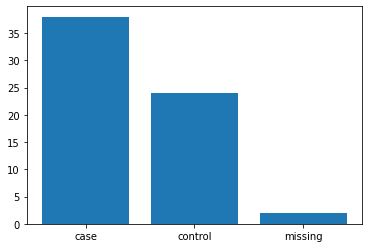

In [329]:
countRemission(EarthA_fam[EarthA_fam[0].isin(IDlist)])

## EarthB

In [26]:
EarthB_fam = pd.read_csv('./Pipelinerun_withPC/EARTH_B/mergedChr/EARTH_setB_merged.fam',sep='\s',header=None)
EarthB_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,1019_EA3725,1019_EA3725,0,0,0,2
1,1043_EA3839,1043_EA3839,0,0,0,2
2,1066_EA4028,1066_EA4028,0,0,0,1
3,1090_EA3886,1090_EA3886,0,0,0,1
4,1117_EA4136,1117_EA4136,0,0,0,2
...,...,...,...,...,...,...
61,822_EA3956,822_EA3956,0,0,0,1
62,847_EA3718,847_EA3718,0,0,0,1
63,86_EA3946,86_EA3946,0,0,0,1
64,870_EA3829,870_EA3829,0,0,0,2


In [28]:
EarthB = openfile("/exports/reum/knevel_lab/EARTH/SetB/clinical/EA_Samples.xlsx",sep=';')
search(EarthB.columns,patterns=['ccp'])

100%|███████████████████████████████████████| 66/66 [00:00<00:00, 361389.12it/s]

Found pattern ccp in column num 46 CCP_Status


['CCP_Status']

In [29]:
EarthB

,EANo,Gender,DOB,PtAge,Visit_BL,Visit_MTX_Start,Rpt_Das_Date,DAS_Int,LatestMTXEnd,MTXEnded_InMTXPeriod,MTX_Duration,MTXEndReason,NonMTXDMARD_InMTXPeriod,NonMTXDMARDStart,HXQStart,HCQ,SLZStart,SLZ,LFNStart,LFN,NofStrdIMIA,DAS28ESR_BL,DAS28CRP_BL,GV_BL,Tender28_BL,Swollen28_BL,ESR_BL,CRP_BL,DAS28ESR_FU,DAS28CRP_FU,GlobalVAS,Tender28,Swollen28,ESR,CRP,dDASESR,dDASCRP,dDASESR_ratio,dDASCRP_ratio,EULAR,EULAR_CRP,Smoking,Alcohol,BMI,SBP,DBP,CCP_Status,RF_Status,EMS,ScanImpression,HAQ_BL,ESR_Remission,ESR_Low_Activity,CRP_Remission,CRP_Low_Activity,Boolean_Remission_ESR,Boolean_Remission_CRP,BL_2C_DAS,FU_2C_DAS,d2C_DAS,Symptom_Duration,HB,IgG,IgA,IgM,AST
0,EA3704,F,1949-02-28,68.666667,2017-10-31,2017-11-03,2018-03-22,4.733333,NaT,N,NaN,NaN,N,NaT,NaT,N,NaT,N,NaT,N,2.0,3.928928,3.219002,20,0,15,39,11,1.795435,1.265533,4.0,0,0,12.0,1.0,2.133494,1.953469,0.543022,0.606855,Good Response,Good Response,False,0.0,28.054110,168.0,111.0,Negative,Negative,60.0,NaN,1.125,Yes,Yes,Yes,Yes,No,Yes,5.363927,0.415888,4.948039,12.0,118.0,7.3,1.91,0.36,18
1,EA3714,F,1968-01-02,49.866667,2017-11-14,2017-11-21,2018-04-23,5.300000,NaT,N,NaN,NaN,Y,2017-11-21,2017-11-21,BL,NaT,N,NaT,N,NaN,3.531166,3.379957,80,0,1,21,16,1.224607,1.637398,7.0,0,0,5.0,4.0,2.306559,1.742559,0.653200,0.515557,Good Response,Good Response,False,5.0,34.090790,115.0,82.0,Positive,Positive,340.0,Definite inflammatory changes,0.750,Yes,Yes,Yes,Yes,Yes,Yes,2.699928,0.659167,2.040761,10.0,130.0,9.1,4.18,1.46,16
2,EA3718,M,1952-03-18,65.675000,2017-11-21,2017-11-28,2018-05-16,5.833333,NaT,N,NaN,NaN,Y,2017-11-28,2017-11-28,BL,NaT,N,NaT,N,1.0,6.228554,6.636743,40,24,22,10,18,3.368812,3.447998,62.0,1,0,16.0,18.0,2.859742,3.188745,0.459134,0.480468,Moderate Response,Moderate Response,False,0.0,42.716049,149.0,75.0,Positive,Negative,60.0,Definite inflammatory changes,2.125,No,No,No,No,No,No,6.457079,1.766663,4.690416,12.0,139.0,8.2,1.98,0.48,19
3,EA3719,F,1964-05-03,53.569444,2017-11-28,2017-12-05,2018-04-03,4.166667,NaT,N,NaN,NaN,N,2018-05-17,NaT,N,2018-05-17,N,NaT,N,1.0,2.666607,3.079398,50,1,1,5,4,1.310000,2.365398,19.0,1,0,2.0,4.0,1.356607,0.714000,0.508739,0.231864,Good Response,Moderate Response,False,14.0,24.287401,132.0,78.0,Positive,Positive,360.0,Definite inflammatory changes,0.750,Yes,Yes,Yes,Yes,No,No,1.000000,0.659167,0.340833,6.0,137.0,10.2,1.59,1.34,25
4,EA3720,M,1970-02-11,47.797222,2017-11-28,2017-11-28,2018-04-17,4.633333,NaT,N,NaN,NaN,Y,2017-11-28,2017-11-28,BL,NaT,N,NaT,N,1.0,6.071740,6.396487,80,15,6,20,57,2.215163,3.269357,27.0,2,4,2.0,4.0,3.856578,3.127130,0.635168,0.488882,Good Response,Moderate Response,True,0.0,23.114187,126.0,80.0,Positive,Positive,NaN,Definite inflammatory changes,2.000,Yes,Yes,No,No,No,No,4.885756,2.659167,2.226588,52.0,113.0,9.6,1.68,1.10,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,EA4201,F,1956-08-20,62.944444,2019-07-30,2019-08-06,2019-12-03,4.100000,NaT,N,NaN,NaN,N,NaT,NaT,N,NaT,N,NaT,N,NaN,5.400068,5.001422,70,10,2,25,11,3.358527,3.340528,20.0,4,1,11.0,6.0,2.041542,1.660894,0.378058,0.332084,Moderate Response,Moderate Response,False,0.0,32.769395,113.0,68.0,Negative,Negative,360.0,Definite inflammatory changes,2.300,No,No,No,No,No,No,2.905158,2.167546,0.737611,31.0,117.0,10.3,2.41,1.52,18
64,EA4208,F,1977-01-11,42.588889,2019-08-13,2019-08-20,2019-11-12,2.966667,NaT,N,NaN,NaN,N,NaT,NaT,N,NaT,N,NaT,N,1.0,3.646824,4.766654,80,7,4,2,5,2.386607,2.865033,50.0,1,0,5.0,5.0,1.260217,1.901621,0.345566,0.398942,Good Response,Good Response,True,2.0,34.367914,108.0,65.0,Negative,Negative,180.0,Definite inflammatory changes,NaN,Yes,Yes,No,Yes,No,No,3.075056,1.075056,2.000000,19.0,143.0,NaN,NaN,NaN,22
65,EA4209,F,1986-10-04,32.858333,2019-08-13,2019-10-07,2020-01-20,5.233333,2019-11-18,Y,1.366667,ADR,Y,2019-11-18,NaT,N,NaT,N,2019-

In [331]:
EarthB_MTX = EarthB[(EarthB['Visit_MTX_Start'] - EarthB['Visit_BL']) <= timedelta(180)]
EarthB_MTX['days_start_MTX'] = EarthB_MTX['Visit_MTX_Start'] - EarthB_MTX['Visit_BL']
EarthB_MTX

,EANo,Gender,DOB,PtAge,Visit_BL,Visit_MTX_Start,Rpt_Das_Date,DAS_Int,LatestMTXEnd,MTXEnded_InMTXPeriod,MTX_Duration,MTXEndReason,NonMTXDMARD_InMTXPeriod,NonMTXDMARDStart,HXQStart,HCQ,SLZStart,SLZ,LFNStart,LFN,NofStrdIMIA,DAS28ESR_BL,DAS28CRP_BL,GV_BL,Tender28_BL,Swollen28_BL,ESR_BL,CRP_BL,DAS28ESR_FU,DAS28CRP_FU,GlobalVAS,Tender28,Swollen28,ESR,CRP,dDASESR,dDASCRP,dDASESR_ratio,dDASCRP_ratio,EULAR,EULAR_CRP,Smoking,Alcohol,BMI,SBP,DBP,CCP_Status,RF_Status,EMS,ScanImpression,HAQ_BL,ESR_Remission,ESR_Low_Activity,CRP_Remission,CRP_Low_Activity,Boolean_Remission_ESR,Boolean_Remission_CRP,BL_2C_DAS,FU_2C_DAS,d2C_DAS,Symptom_Duration,HB,IgG,IgA,IgM,AST,days_start_MTX
0,EA3704,F,1949-02-28,68.666667,2017-10-31,2017-11-03,2018-03-22,4.733333,NaT,N,NaN,NaN,N,NaT,NaT,N,NaT,N,NaT,N,2.0,3.928928,3.219002,20,0,15,39,11,1.795435,1.265533,4.0,0,0,12.0,1.0,2.133494,1.953469,0.543022,0.606855,Good Response,Good Response,False,0.0,28.054110,168.0,111.0,Negative,Negative,60.0,NaN,1.125,Yes,Yes,Yes,Yes,No,Yes,5.363927,0.415888,4.948039,12.0,118.0,7.3,1.91,0.36,18,3 days
1,EA3714,F,1968-01-02,49.866667,2017-11-14,2017-11-21,2018-04-23,5.300000,NaT,N,NaN,NaN,Y,2017-11-21,2017-11-21,BL,NaT,N,NaT,N,NaN,3.531166,3.379957,80,0,1,21,16,1.224607,1.637398,7.0,0,0,5.0,4.0,2.306559,1.742559,0.653200,0.515557,Good Response,Good Response,False,5.0,34.090790,115.0,82.0,Positive,Positive,340.0,Definite inflammatory changes,0.750,Yes,Yes,Yes,Yes,Yes,Yes,2.699928,0.659167,2.040761,10.0,130.0,9.1,4.18,1.46,16,7 days
2,EA3718,M,1952-03-18,65.675000,2017-11-21,2017-11-28,2018-05-16,5.833333,NaT,N,NaN,NaN,Y,2017-11-28,2017-11-28,BL,NaT,N,NaT,N,1.0,6.228554,6.636743,40,24,22,10,18,3.368812,3.447998,62.0,1,0,16.0,18.0,2.859742,3.188745,0.459134,0.480468,Moderate Response,Moderate Response,False,0.0,42.716049,149.0,75.0,Positive,Negative,60.0,Definite inflammatory changes,2.125,No,No,No,No,No,No,6.457079,1.766663,4.690416,12.0,139.0,8.2,1.98,0.48,19,7 days
3,EA3719,F,1964-05-03,53.569444,2017-11-28,2017-12-05,2018-04-03,4.166667,NaT,N,NaN,NaN,N,2018-05-17,NaT,N,2018-05-17,N,NaT,N,1.0,2.666607,3.079398,50,1,1,5,4,1.310000,2.365398,19.0,1,0,2.0,4.0,1.356607,0.714000,0.508739,0.231864,Good Response,Moderate Response,False,14.0,24.287401,132.0,78.0,Positive,Positive,360.0,Definite inflammatory changes,0.750,Yes,Yes,Yes,Yes,No,No,1.000000,0.659167,0.340833,6.0,137.0,10.2,1.59,1.34,25,7 days
4,EA3720,M,1970-02-11,47.797222,2017-11-28,2017-11-28,2018-04-17,4.633333,NaT,N,NaN,NaN,Y,2017-11-28,2017-11-28,BL,NaT,N,NaT,N,1.0,6.071740,6.396487,80,15,6,20,57,2.215163,3.269357,27.0,2,4,2.0,4.0,3.856578,3.127130,0.635168,0.488882,Good Response,Moderate Response,True,0.0,23.114187,126.0,80.0,Positive,Positive,NaN,Definite inflammatory changes,2.000,Yes,Yes,No,No,No,No,4.885756,2.659167,2.226588,52.0,113.0,9.6,1.68,1.10,22,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,EA4201,F,1956-08-20,62.944444,2019-07-30,2019-08-06,2019-12-03,4.100000,NaT,N,NaN,NaN,N,NaT,NaT,N,NaT,N,NaT,N,NaN,5.400068,5.001422,70,10,2,25,11,3.358527,3.340528,20.0,4,1,11.0,6.0,2.041542,1.660894,0.378058,0.332084,Moderate Response,Moderate Response,False,0.0,32.769395,113.0,68.0,Negative,Negative,360.0,Definite inflammatory changes,2.300,No,No,No,No,No,No,2.905158,2.167546,0.737611,31.0,117.0,10.3,2.41,1.52,18,7 days
64,EA4208,F,1977-01-11,42.588889,2019-08-13,2019-08-20,2019-11-12,2.966667,NaT,N,NaN,NaN,N,NaT,NaT,N,NaT,N,NaT,N,1.0,3.646824,4.766654,80,7,4,2,5,2.386607,2.865033,50.0,1,0,5.0,5.0,1.260217,1.901621,0.345566,0.398942,Good Response,Good Response,True,2.0,34.367914,108.0,65.0,Negative,Negative,180.0,Definite inflammatory changes,NaN,Yes,Yes,No,Yes,No,No,3.075056,1.075056,2.000000,19.0,143.0,NaN,NaN,NaN,22,7 days
65,EA4209,F,1986-10-04,32.858333,2019-08-13,2019-10-07,2020-01-

In [123]:
#use all samples, 66
EarthB_fam.to_csv("/exports/reum/CKe/Pipelinerun_withPC/MTXsubset/EARTH_setB_merged_MTX.fam",sep='\t',index=False,header=False)

(34, 32, 0)

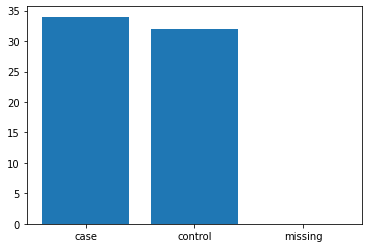

In [332]:
countRemission(EarthB_fam)

## Madrid

In [8]:
Madrid = openfile("/exports/reum/knevel_lab/Madrid/clinical/Clinical_data_GWAS_patients_HUP.dta")
Madrid_additional = openfile("/exports/reum/knevel_lab/Scripts_Samantha/GWAS_runscripts/GWAS_scripts/input_files_used/madrid/Additional clincal data pacients GWAS HUP.xls")

In [9]:
search(Madrid.columns)

100%|███████████████████████████████████████| 58/58 [00:00<00:00, 114264.74it/s]

Found pattern mtx in column num 6 dosis_mtx_v1
Found pattern mtx in column num 17 dosis_mtx_v2
Found pattern mtx in column num 34 dosis_mtx_v3
Found pattern sdai in column num 48 sdai_v3
Found pattern cdai in column num 49 cdai_v3


['dosis_mtx_v1', 'dosis_mtx_v2', 'dosis_mtx_v3', 'sdai_v3', 'cdai_v3']

In [10]:
search(Madrid_additional.columns)

100%|████████████████████████████████████████| 52/52 [00:00<00:00, 65536.00it/s]

Found pattern sdai in column num 12 sdai_v1
Found pattern cdai in column num 13 cdai_v1
Found pattern sdai in column num 24 sdai_v2
Found pattern cdai in column num 25 cdai_v2
Found pattern sdai in column num 36 sdai_v3
Found pattern cdai in column num 37 cdai_v3


['sdai_v1', 'cdai_v1', 'sdai_v2', 'cdai_v2', 'sdai_v3', 'cdai_v3']

In [11]:
Madrid

,codigo2,tabaco,fr,fechaini,sexo,cort_v1,dosis_mtx_v1,dosis_leflu_v1,dosis_antipal_v1,dosis_szp_v1,dosis_oro_v1,dosis_csa_v1,a_tnf_v1,aba_v1,toci_v1,ritu_v1,cort_v2,dosis_mtx_v2,dosis_leflu_v2,dosis_antipal_v2,dosis_szp_v2,dosis_oro_v2,dosis_csa_v2,a_tnf_v2,aba_v2,toci_v2,ritu_v2,vgepac_v3,vgemed_v3,nad_v3,nat_v3,vsg_v3,pcr_v3,cort_v3,dosis_mtx_v3,dosis_leflu_v3,dosis_antipal_v3,dosis_szp_v3,dosis_oro_v3,dosis_csa_v3,a_tnf_v3,aba_v3,toci_v3,ritu_v3,das28_v3,das28pcr_v3,das28cat_v3,das28pcrcat_v3,sdai_v3,cdai_v3,cort_v4,edadinienf,tevol_v1,tevol_v3,ccpsn,hupi_v3,hupicat_v3,cortic_1yr
0,536,1.0,1,2012-08-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,14.0,0.0,0.0,29.0,0.30,0.0,17.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.525107,1.627066,Remision,Remision,2.900000,2.600000,0.0,65.180824,2.266667,14.400000,1.0,1.0,Remision,0.000
1,539,0.0,0,2012-08-20,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,17.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,45.0,6.0,1.0,21.0,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.510880,3.589247,Act. moderada,Act. baja,16.799999,16.700001,0.0,48.515068,3.133333,15.866667,1.0,7.0,Act. moderada,100.000
2,541,2.0,1,2012-03-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,25.0,0.0,3.0,13.0,0.60,0.0,20.0,8.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.504439,2.369502,Remision,Act. baja,7.700000,7.100000,0.0,60.082191,8.666667,22.366667,1.0,3.5,Act. leve,1528.125
3,542,1.0,0,2012-06-21,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,5.0,15.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,13.0,0.10,2.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.879465,1.293533,Remision,Remision,0.700000,0.600000,0.0,62.964382,6.533333,19.500000,0.0,0.0,Remision,1642.500
4,545,0.0,1,2012-03-01,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,0.0,2.0,56.0,0.20,5.0,20.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.255726,1.793480,Act. moderada,Remision,4.300000,4.100000,0.0,69.490410,10.866667,23.733334,1.0,2.5,Act. leve,75.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,836,1.0,1,2019-05-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,5.0,3.0,0.0,25.0,0.23,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.853162,2.989761,Act. moderada,Act. baja,8.230000,8.000000,NaN,63.967125,0.400000,13.233334,1.0,5.0,Act. leve,0.000
119,839,2.0,1,2018-06-15,Hombre,0.0,0.0,0,0,0,0,0,0,0,0,0,2.5,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,75.0,12.0,7.0,79.0,1.26,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.590000,NaN,Act. alta,NaN,33.259998,NaN,NaN,62.526028,12.066667,NaN,1.0,11.5,Act. alta,NaN
120,842,1.0,1,2019-05-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.06,0.0,0.0,0.0,0.0,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.485203,1.129201,Remision,Remision,0.360000,0.300000,NaN,31.545206,1.233333,13.233334,1.0,0.0,Remision,0.000
121,843,0.0,1,2019-05-15,Mujer,0.0,15.0,0,0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.980824,1.566667,NaN,1.0,NaN,NaN,0.000


In [12]:
Madrid_additional

,codigo2,fechaini,vgepac_v1,vgemed_v1,nad_v1,nat_v1,vsg_v1,pcr_v1,das28_v1,das28pcr_v1,das28cat_v1,das28pcrcat_v1,sdai_v1,cdai_v1,vgepac_v2,vgemed_v2,nad_v2,nat_v2,vsg_v2,pcr_v2,das28_v2,das28pcr_v2,das28cat_v2,das28pcrcat_v2,sdai_v2,cdai_v2,vgepac_v3,vgemed_v3,nad_v3,nat_v3,vsg_v3,pcr_v3,das28_v3,das28pcr_v3,das28cat_v3,das28pcrcat_v3,sdai_v3,cdai_v3,peso,talla,bmi,edadinienf,tevol_v1,tevol_v2,tevol_v3,fecha1fme,hupi_v1,hupicat_v1,hupi_v2,hupicat_v2,hupi_v3,hupicat_v3
0,536,2012-08-15,47,25,1,2,46.0,0.60,4.294029,3.274508,Act. moderada,Act. baja,10.800000,10.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,14.0,0.0,0.0,29.0,0.30,2.525107,1.627066,Remision,Remision,2.900000,2.600000,92.5,1.610,35.685352,65.180824,2.266667,NaN,14.400000,2012-10-23,6.0,Act. moderada,NaN,NaN,1.0,Remision
1,539,2012-08-20,27,22,2,2,19.0,0.10,3.627047,2.775472,Act. moderada,Act. baja,9.000000,8.900000,81.0,54.0,9.0,4.0,15.0,0.10,5.269635,4.583533,Act. alta,Act. moderada,26.60,26.5,52.0,45.0,6.0,1.0,21.0,0.10,4.510880,3.589247,Act. moderada,Act. baja,16.799999,16.700001,60.0,1.720,20.281233,48.515068,3.133333,9.433333,15.866667,2012-11-24,3.5,Act. leve,8.0,Act. moderada,7.0,Act. moderada
2,541,2012-03-15,45,58,2,9,50.0,4.00,5.000376,4.558846,Act. moderada,Act. moderada,25.299999,21.299999,29.0,35.0,0.0,3.0,20.0,0.30,2.987987,2.350040,Act. baja,Act. baja,9.70,9.4,16.0,25.0,0.0,3.0,13.0,0.60,2.504439,2.369502,Remision,Act. baja,7.700000,7.100000,55.0,1.470,25.452358,60.082191,8.666667,13.900000,22.366667,2012-12-05,9.0,Act. moderada,3.5,Act. leve,3.5,Act. leve
3,542,2012-06-21,55,75,10,10,17.0,0.20,5.409563,4.781814,Act. alta,Act. moderada,33.200001,33.000000,12.0,14.0,0.0,1.0,14.0,0.00,2.295340,1.408000,Remision,Remision,3.60,3.6,6.0,0.0,0.0,0.0,13.0,0.10,1.879465,1.293533,Remision,Remision,0.700000,0.600000,57.0,1.640,21.192743,62.964382,6.533333,14.233334,19.500000,2013-01-08,9.5,Act. alta,1.0,Remision,0.0,Remision
4,545,2012-03-01,65,49,7,9,40.0,1.30,5.813837,5.141681,Act. alta,Act. alta,28.700001,27.400000,8.0,10.0,0.0,1.0,37.0,0.10,2.919642,1.601533,Act. baja,Remision,2.90,2.8,3.0,18.0,0.0,2.0,56.0,0.20,3.255726,1.793480,Act. moderada,Remision,4.300000,4.100000,55.5,1.480,25.337837,69.490410,10.866667,16.933332,23.733334,2013-01-22,11.5,Act. alta,2.5,Act. leve,2.5,Act. leve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,836,2019-05-15,66,25,10,1,31.0,0.50,5.378666,4.579909,Act. alta,Act. moderada,20.600000,20.100000,44.0,13.0,4.0,0.0,46.0,0.27,4.416049,3.167000,Act. moderada,Act. baja,9.97,9.7,45.0,5.0,3.0,0.0,25.0,0.23,3.853162,2.989761,Act. moderada,Act. baja,8.230000,8.000000,63.0,1.510,27.630367,63.967125,0.400000,6.233333,13.233334,2019-05-28,8.5,Act. moderada,5.5,Act. moderada,5.0,Act. leve
119,839,2018-06-15,55,37,9,4,58.0,0.37,5.852310,4.527122,Act. alta,Act. moderada,22.570000,22.200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,1.665,23.807590,62.526028,12.066667,NaN,NaN,2019-06-14,9.5,Act. alta,NaN,NaN,NaN,NaN
120,842,2019-05-15,91,65,14,9,16.0,0.76,6.150140,5.943963,Act. alta,Act. alta,39.360001,38.599998,2.0,0.0,0.0,0.0,6.0,0.06,1.282232,1.157201,Remision,Remision,0.26,0.2,0.0,3.0,0.0,0.0,2.0,0.06,0.485203,1.129201,Remision,Remision,0.360000,0.300000,58.0,1.560,23.833004,31.545206,1.233333,6.700000,13.233334,2019-06-24,10.0,Act. alta,0.0,Remision,0.0,Remision
121,843,2019-05-15,90,65,0,10,35.0,0.71,4.634181,3.858509,Act. moderada,Act. moderada,26.209999,25.500000,10.0,5.0,0.0,1.0,10.0,0.56,2.031810,2.059345,Remision,Remision,3.06,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.5,1.560,26.093031,38.980824,1.566667,8.566667,NaN,2019-07-02,8.0,Act. moderada,1.5,Remision,NaN,NaN


In [19]:
loc_list_MTX[2]

'./Pipelinerun_withPC/Madrid/mergedChr/madrid_merged.fam'

In [15]:
Madrid_fam = pd.read_csv(loc_list_MTX[2],sep='\s',header=None)
Madrid_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,1018_ARC796,1018_ARC796,0,0,0,-9
1,1020_ARC552,1020_ARC552,0,0,0,1
2,1042_HCSC06,1042_HCSC06,0,0,0,-9
3,1044_ARC602,1044_ARC602,0,0,0,1
4,1068_ARC646,1068_ARC646,0,0,0,2
...,...,...,...,...,...,...
136,922_ARC560,922_ARC560,0,0,0,1
137,944_HCSC12,944_HCSC12,0,0,0,-9
138,946_ARC611,946_ARC611,0,0,0,1
139,970_ARC666,970_ARC666,0,0,0,2


In [18]:
Madrid_MTX = Madrid[(Madrid['dosis_mtx_v1'].fillna(0)+Madrid['dosis_mtx_v2'].fillna(0))!=0]
Madrid_MTX

,codigo2,tabaco,fr,fechaini,sexo,cort_v1,dosis_mtx_v1,dosis_leflu_v1,dosis_antipal_v1,dosis_szp_v1,dosis_oro_v1,dosis_csa_v1,a_tnf_v1,aba_v1,toci_v1,ritu_v1,cort_v2,dosis_mtx_v2,dosis_leflu_v2,dosis_antipal_v2,dosis_szp_v2,dosis_oro_v2,dosis_csa_v2,a_tnf_v2,aba_v2,toci_v2,ritu_v2,vgepac_v3,vgemed_v3,nad_v3,nat_v3,vsg_v3,pcr_v3,cort_v3,dosis_mtx_v3,dosis_leflu_v3,dosis_antipal_v3,dosis_szp_v3,dosis_oro_v3,dosis_csa_v3,a_tnf_v3,aba_v3,toci_v3,ritu_v3,das28_v3,das28pcr_v3,das28cat_v3,das28pcrcat_v3,sdai_v3,cdai_v3,cort_v4,edadinienf,tevol_v1,tevol_v3,ccpsn,hupi_v3,hupicat_v3,cortic_1yr
1,539,0.0,0,2012-08-20,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,17.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,45.0,6.0,1.0,21.0,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.510880,3.589247,Act. moderada,Act. baja,16.799999,16.700001,0.0,48.515068,3.133333,15.866667,1.0,7.0,Act. moderada,100.000
2,541,2.0,1,2012-03-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,25.0,0.0,3.0,13.0,0.60,0.0,20.0,8.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.504439,2.369502,Remision,Act. baja,7.700000,7.100000,0.0,60.082191,8.666667,22.366667,1.0,3.5,Act. leve,1528.125
3,542,1.0,0,2012-06-21,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,5.0,15.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,13.0,0.10,2.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.879465,1.293533,Remision,Remision,0.700000,0.600000,0.0,62.964382,6.533333,19.500000,0.0,0.0,Remision,1642.500
4,545,0.0,1,2012-03-01,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,0.0,2.0,56.0,0.20,5.0,20.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.255726,1.793480,Act. moderada,Remision,4.300000,4.100000,0.0,69.490410,10.866667,23.733334,1.0,2.5,Act. leve,75.000
5,547,1.0,1,2012-12-01,Hombre,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,7.0,0.0,0.0,30.0,0.30,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.660838,1.739066,Act. baja,Remision,3.000000,2.700000,0.0,58.495892,2.066667,14.533334,1.0,2.5,Act. leve,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,836,1.0,1,2019-05-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,5.0,3.0,0.0,25.0,0.23,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.853162,2.989761,Act. moderada,Act. baja,8.230000,8.000000,NaN,63.967125,0.400000,13.233334,1.0,5.0,Act. leve,0.000
119,839,2.0,1,2018-06-15,Hombre,0.0,0.0,0,0,0,0,0,0,0,0,0,2.5,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,75.0,12.0,7.0,79.0,1.26,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.590000,NaN,Act. alta,NaN,33.259998,NaN,NaN,62.526028,12.066667,NaN,1.0,11.5,Act. alta,NaN
120,842,1.0,1,2019-05-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.06,0.0,0.0,0.0,0.0,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.485203,1.129201,Remision,Remision,0.360000,0.300000,NaN,31.545206,1.233333,13.233334,1.0,0.0,Remision,0.000
121,843,0.0,1,2019-05-15,Mujer,0.0,15.0,0,0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.980824,1.566667,NaN,1.0,NaN,NaN,0.000


In [173]:
Madrid_fam['id'] = Madrid_fam[0].str.replace('^.*_',"").str.replace("^.*C","").str.lstrip("0").astype(int)
Madrid_MTX = pd.merge(Madrid_MTX,Madrid_fam,how='inner',left_on='codigo2',right_on='id')
Madrid_MTX

/tmp/ipykernel_2371238/200907256.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  Madrid_fam['id'] = Madrid_fam[0].str.replace('^.*_',"").str.replace("^.*C","").str.lstrip("0").astype(int)


,codigo2,tabaco,fr,fechaini,sexo,cort_v1,dosis_mtx_v1,dosis_leflu_v1,dosis_antipal_v1,dosis_szp_v1,dosis_oro_v1,dosis_csa_v1,a_tnf_v1,aba_v1,toci_v1,ritu_v1,cort_v2,dosis_mtx_v2,dosis_leflu_v2,dosis_antipal_v2,dosis_szp_v2,dosis_oro_v2,dosis_csa_v2,a_tnf_v2,aba_v2,toci_v2,ritu_v2,vgepac_v3,vgemed_v3,nad_v3,nat_v3,vsg_v3,pcr_v3,cort_v3,dosis_mtx_v3,dosis_leflu_v3,dosis_antipal_v3,dosis_szp_v3,dosis_oro_v3,dosis_csa_v3,a_tnf_v3,aba_v3,toci_v3,ritu_v3,das28_v3,das28pcr_v3,das28cat_v3,das28pcrcat_v3,sdai_v3,cdai_v3,cort_v4,edadinienf,tevol_v1,tevol_v3,ccpsn,hupi_v3,hupicat_v3,cortic_1yr,0,1,2,3,4,5,id
0,539,0.0,0,2012-08-20,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,17.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,45.0,6.0,1.0,21.0,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.510880,3.589247,Act. moderada,Act. baja,16.799999,16.700001,0.0,48.515068,3.133333,15.866667,1.0,7.0,Act. moderada,100.000,408_ARC539,408_ARC539,0,0,0,1,539
1,541,2.0,1,2012-03-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,25.0,0.0,3.0,13.0,0.60,0.0,20.0,8.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.504439,2.369502,Remision,Act. baja,7.700000,7.100000,0.0,60.082191,8.666667,22.366667,1.0,3.5,Act. leve,1528.125,800_ARC541,800_ARC541,0,0,0,1,541
2,542,1.0,0,2012-06-21,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,5.0,15.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,13.0,0.10,2.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.879465,1.293533,Remision,Remision,0.700000,0.600000,0.0,62.964382,6.533333,19.500000,0.0,0.0,Remision,1642.500,1192_ARC542,1192_ARC542,0,0,0,2,542
3,545,0.0,1,2012-03-01,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,0.0,2.0,56.0,0.20,5.0,20.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.255726,1.793480,Act. moderada,Remision,4.300000,4.100000,0.0,69.490410,10.866667,23.733334,1.0,2.5,Act. leve,75.000,1584_ARC545,1584_ARC545,0,0,0,1,545
4,547,1.0,1,2012-12-01,Hombre,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,7.0,0.0,0.0,30.0,0.30,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.660838,1.739066,Act. baja,Remision,3.000000,2.700000,0.0,58.495892,2.066667,14.533334,1.0,2.5,Act. leve,0.000,1976_ARC547,1976_ARC547,0,0,0,1,547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,836,1.0,1,2019-05-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,5.0,3.0,0.0,25.0,0.23,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.853162,2.989761,Act. moderada,Act. baja,8.230000,8.000000,NaN,63.967125,0.400000,13.233334,1.0,5.0,Act. leve,0.000,1900_ARC836,1900_ARC836,0,0,0,1,836
90,839,2.0,1,2018-06-15,Hombre,0.0,0.0,0,0,0,0,0,0,0,0,0,2.5,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,75.0,12.0,7.0,79.0,1.26,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.590000,NaN,Act. alta,NaN,33.259998,NaN,NaN,62.526028,12.066667,NaN,1.0,11.5,Act. alta,NaN,2291_ARC839,2291_ARC839,0,0,0,-9,839
91,842,1.0,1,2019-05-15,Mujer,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.06,0.0,0.0,0.0,0.0,1250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.485203,1.129201,Remision,Remision,0.360000,0.300000,NaN,31.545206,1.233333,13.233334,1.0,0.0,Remision,0.000,62_ARC842,62_ARC842,0,0,0,2,842
92,843,0.0,1,2019-05-15,Mujer,0.0,15.0,0,0,0,0,0,0,0,0,0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.980824,1.566667,NaN,1.0,NaN,NaN,0.000,454_ARC843,454_ARC843,0,0,0,2,843


In [175]:
#94 samples
Madrid_MTX.loc[:,[0,1,2,3,4,5]].to_csv("/exports/reum/CKe/Pipelinerun_withPC/MTXsubset/Madrid_merged_MTX.fam",sep='\t',index=False,header=False)

(42, 48, 4)

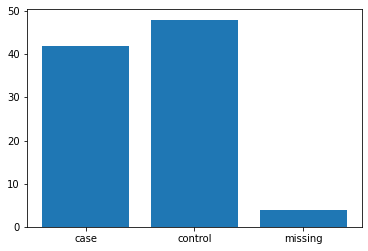

In [333]:
countRemission(Madrid_MTX.loc[:,[0,1,2,3,4,5]])

## RAMS

In [176]:
RAMS_fam = pd.read_csv(loc_list_MTX[3],sep='\s',header=None)
RAMS_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,RAMS_1_RAMS_1,RAMS_1_RAMS_1,0,0,0,1
1,RAMS_10_RAMS_10,RAMS_10_RAMS_10,0,0,0,1
2,RAMS_100_RAMS_100,RAMS_100_RAMS_100,0,0,0,1
3,RAMS_102_RAMS_102,RAMS_102_RAMS_102,0,0,0,1
4,RAMS_103_RAMS_103,RAMS_103_RAMS_103,0,0,0,1
...,...,...,...,...,...,...
240,RAMS_89_RAMS_89,RAMS_89_RAMS_89,0,0,0,1
241,RAMS_91_RAMS_91,RAMS_91_RAMS_91,0,0,0,1
242,RAMS_93_RAMS_93,RAMS_93_RAMS_93,0,0,0,2
243,RAMS_95_RAMS_95,RAMS_95_RAMS_95,0,0,0,1


In [177]:
RAMS_pheno = openfile("/exports/reum/knevel_lab/RAMS/clinical/pheno.csv")
RAMS_pheno

,fid_anon,iid_anon,fupno,start_dose_mtx,steroids,vaspat,tjc28_value,sjc28_value,DAS28_CRP,sex,age_baseline,disease_duration_at_baseline_mths,logCRP,smoke_baseline
0,RAMS_1,RAMS_1,6 Mo,NaN,No,78.0,27.0,16.0,7.087547,NaN,NaN,NaN,2.793616,NaN
1,RAMS_1,RAMS_1,Baseline,15.0,No,77.0,24.0,11.0,6.549305,F,56.92845,17.311480,2.331172,current
2,RAMS_3,RAMS_3,Baseline,15.0,No,50.0,5.0,7.0,4.952939,M,43.01267,14.032790,3.610918,current
3,RAMS_3,RAMS_3,3 Mo,NaN,NaN,30.0,3.0,2.0,3.695989,NaN,NaN,NaN,2.639057,NaN
4,RAMS_3,RAMS_3,6 Mo,NaN,No,90.0,0.0,0.0,3.378795,NaN,NaN,NaN,3.218876,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,RAMS_526,RAMS_526,Baseline,7.5,Yes,26.0,2.0,0.0,3.047825,F,48.36700,4.524590,2.588516,never
913,RAMS_527,RAMS_527,3 Mo,NaN,NaN,24.0,5.0,0.0,3.193232,NaN,NaN,NaN,1.791759,NaN
914,RAMS_527,RAMS_527,Baseline,10.0,No,50.0,16.0,10.0,5.430471,M,77.39542,7.606557,1.791759,never
915,RAMS_527,RAMS_527,12 Mo,NaN,No,28.0,0.0,0.0,1.997033,NaN,NaN,NaN,1.791759,NaN


In [181]:
RAMS_pheno['fupno'].unique()

array(['6 Mo', 'Baseline', '3 Mo', '12 Mo'], dtype=object)

In [189]:
RAMS_MTX = RAMS_pheno[(RAMS_pheno['fupno']!='12 Mo') & (RAMS_pheno['start_dose_mtx'] >0)]
RAMS_MTX

,fid_anon,iid_anon,fupno,start_dose_mtx,steroids,vaspat,tjc28_value,sjc28_value,DAS28_CRP,sex,age_baseline,disease_duration_at_baseline_mths,logCRP,smoke_baseline
1,RAMS_1,RAMS_1,Baseline,15.0,No,77.0,24.0,11.0,6.549305,F,56.92845,17.311480,2.331172,current
2,RAMS_3,RAMS_3,Baseline,15.0,No,50.0,5.0,7.0,4.952939,M,43.01267,14.032790,3.610918,current
6,RAMS_5,RAMS_5,Baseline,15.0,No,30.0,14.0,12.0,5.214852,F,56.76412,13.934430,2.137710,never
12,RAMS_7,RAMS_7,Baseline,15.0,No,21.0,7.0,7.0,4.021085,M,81.11469,8.786885,1.512927,previous
16,RAMS_10,RAMS_10,Baseline,10.0,No,40.0,12.0,3.0,5.416970,M,71.00582,453.278700,4.089164,never
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,RAMS_521,RAMS_521,Baseline,10.0,No,10.0,14.0,8.0,5.356484,F,80.58610,147.508200,3.803324,previous
902,RAMS_522,RAMS_522,Baseline,10.0,No,85.0,4.0,4.0,5.123154,M,41.29545,3.245902,3.592093,previous
906,RAMS_525,RAMS_525,Baseline,7.5,No,8.0,8.0,2.0,4.185805,F,59.14960,3.344262,3.149740,previous
912,RAMS_526,RAMS_526,Baseline,7.5,Yes,26.0,2.0,0.0,3.047825,F,48.36700,4.524590,2.588516,never


In [192]:
RAMS_MTX['id'] = RAMS_MTX['fid_anon']+"_"+RAMS_MTX['iid_anon']
RAMS_MTX

/tmp/ipykernel_2371238/2122168638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RAMS_MTX['id'] = RAMS_MTX['fid_anon']+"_"+RAMS_MTX['iid_anon']


,fid_anon,iid_anon,fupno,start_dose_mtx,steroids,vaspat,tjc28_value,sjc28_value,DAS28_CRP,sex,age_baseline,disease_duration_at_baseline_mths,logCRP,smoke_baseline,id
1,RAMS_1,RAMS_1,Baseline,15.0,No,77.0,24.0,11.0,6.549305,F,56.92845,17.311480,2.331172,current,RAMS_1_RAMS_1
2,RAMS_3,RAMS_3,Baseline,15.0,No,50.0,5.0,7.0,4.952939,M,43.01267,14.032790,3.610918,current,RAMS_3_RAMS_3
6,RAMS_5,RAMS_5,Baseline,15.0,No,30.0,14.0,12.0,5.214852,F,56.76412,13.934430,2.137710,never,RAMS_5_RAMS_5
12,RAMS_7,RAMS_7,Baseline,15.0,No,21.0,7.0,7.0,4.021085,M,81.11469,8.786885,1.512927,previous,RAMS_7_RAMS_7
16,RAMS_10,RAMS_10,Baseline,10.0,No,40.0,12.0,3.0,5.416970,M,71.00582,453.278700,4.089164,never,RAMS_10_RAMS_10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,RAMS_521,RAMS_521,Baseline,10.0,No,10.0,14.0,8.0,5.356484,F,80.58610,147.508200,3.803324,previous,RAMS_521_RAMS_521
902,RAMS_522,RAMS_522,Baseline,10.0,No,85.0,4.0,4.0,5.123154,M,41.29545,3.245902,3.592093,previous,RAMS_522_RAMS_522
906,RAMS_525,RAMS_525,Baseline,7.5,No,8.0,8.0,2.0,4.185805,F,59.14960,3.344262,3.149740,previous,RAMS_525_RAMS_525
912,RAMS_526,RAMS_526,Baseline,7.5,Yes,26.0,2.0,0.0,3.047825,F,48.36700,4.524590,2.588516,never,RAMS_526_RAMS_526


In [197]:
#240 samples
RAMS_fam[RAMS_fam[0].isin(RAMS_MTX['id'])].to_csv("/exports/reum/CKe/Pipelinerun_withPC/MTXsubset/RAMS_merged_MTX.fam",sep='\t',index=False,header=False)

(75, 165, 0)

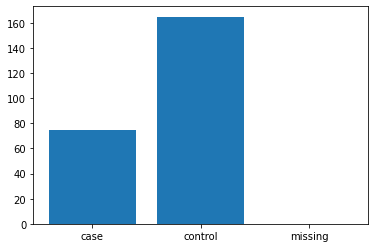

In [334]:
countRemission(RAMS_fam[RAMS_fam[0].isin(RAMS_MTX['id'])])

## Vienna

In [254]:
vienna_fam = pd.read_csv(loc_list_MTX[4],sep='\s',header=None)
vienna_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,10_1130820744,10_1130820744,0,0,0,2
1,1012_1041715812,1012_1041715812,0,0,0,2
2,1014_1131619222,1014_1131619222,0,0,0,2
3,1015_1150204122,1015_1150204122,0,0,0,1
4,1017_1041664226,1017_1041664226,0,0,0,1
...,...,...,...,...,...,...
401,967_1153937793,967_1153937793,0,0,0,-9
402,988_1153942083,988_1153942083,0,0,0,1
403,989_1085427379,989_1085427379,0,0,0,2
404,990_1150146097,990_1150146097,0,0,0,2


In [200]:
Vienna = openfile("/exports/reum/knevel_lab/Vienna/clinical/Rachel_data_ready_to deliver.csv",sep=';')
Vienna

,desc,patient,followup,visit_nr,Eintrt_datum,sex,age,Beschwerdebeginn,Beschwerdedauer,Erstdiagnose,Krankenheitsdauer,Nikotin,Nikotin_text,Analgetika,Kortison,Kortison_merkmal,KortisonStoss,KortisonDosis,NSAIDs,CRP,ESR,PGA,EGA,PAIN,HAQ,SJC28,TJC28,TJC32,SJC32,RF,CCP,DAS_esr,DAS_ESR_S,DAS_crp,SDAI,SDAI_S,CDAI,CDAI_S,rf_pos,ccp_pos,DMARD_Start,MTX_DOSIS,Arava_DOSIS,Salazopyrin_DOSIS,trtment,tr_visit,tr_dur,tr_b,tr_e,trt_course,DMARD__cat,care_dur,RRECEPT_B,locality,PTPN_22,STAT_4,CTLA_4,TRAF1_C5,TNFAIP3,AFF3,IRF5,PADI4,hla1,hla2,shared_epitope,@___merge,filter__,discrib,SampleID_last,@_merge
0,clin,2,4/11/2007,1,4/11/2007,F,"49,5",4/1/2007,0,4/11/2007,0,0,nein,False,1,ja,False,50,True,",3",16,36,34,41,",25",4,7,7,4,12,"1,1","4,48643283976402",MDA,"4,00468670419933","18,3",MDA,18,MDA,0,0,8/2/2007,20,,,Mtx,1,8,4/11/2007,12/6/2007,1,MTX,0,,W,GG,GG,AG,AA,GG,TT,TT,CT,DRB1*01:01:01,DRB1*15:01:01:01Â,1,3,1,BOTH,1085421526,3
1,both,2,4/26/2007,2,4/11/2007,F,"49,6",4/1/2007,",1",4/11/2007,0,0,nein,False,1,ja,False,5,True,",32",17,32,31,46,",625",4,9,10,4,12,"1,4","4,67124934083935",MDA,"4,16463042910416","19,62",MDA,"19,3",MDA,0,0,8/2/2007,20,,,Mtx,2,8,4/11/2007,12/6/2007,1,MTX,0,,W,GG,GG,AG,AA,GG,TT,TT,CT,DRB1*01:01:01,DRB1*15:01:01:01Â,1,3,0,BOTH,1085421526,3
2,clin,2,8/2/2007,3,4/11/2007,F,"49,8",4/1/2007,",3",4/11/2007,",3",0,nein,False,1,ja,False,5,True,",34",16,24,6,31,",5",0,3,3,0,,"1,7","3,24676055780642",MDA,"2,79932608697129","6,34",LDA,6,LDA,0,0,8/2/2007,15,,,Mtx,3,8,4/11/2007,12/6/2007,1,MTX,3,,W,GG,GG,AG,AA,GG,TT,TT,CT,DRB1*01:01:01,DRB1*15:01:01:01Â,1,3,0,BOTH,1085421526,3
3,both,2,12/6/2007,4,4/11/2007,F,"50,2",4/1/2007,",7",4/11/2007,",7",0,nein,False,1,ja,False,5,True,",42",22,31,3,33,",625",0,4,4,0,12,1,"3,71772971735082",MDA,"3,10751710521146","7,82",LDA,"7,4",LDA,0,0,8/2/2007,,,,,1,9,12/6/2007,9/1/2008,2,,7,,W,GG,GG,AG,AA,GG,TT,TT,CT,DRB1*01:01:01,DRB1*15:01:01:01Â,1,3,0,BOTH,1085421526,3
4,both,4,3/14/2007,1,3/14/2007,W,"51,3",,,,,2,,False,1,ja,False,"7,5",False,",68",54,74,8,72,",625",0,6,6,0,12,"1,3","5,20000308855357",HDA,"4,10719880008898","14,88",MDA,"14,2",MDA,0,0,3/14/2007,10,,,Mtx,1,"35,1",3/14/2007,1/29/2010,1,MTX,0,1,W,GG,GG,AA,AG,GG,AT,CT,TT,DRB1*07:01:01:01,DRB1*12:01:01Â,0,3,1,BOTH,1031467068,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,clin,4239,5/21/2014,2,2/14/2014,W,"45,4",2/1/2012,"2,3",2/14/2014,",3",1,ja,False,1,ja,False,"6,25",False,"1,09",28,56,9,24,"1,375",1,1,2,1,77,,"3,95654315712264",MDA,"3,47555382404229","9,59",LDA,"8,5",LDA,1,1,2/14/2014,25,,,Mtx,2,"15,1",2/14/2014,5/13/2015,1,MTX,3,,,,,,,,,,,,,,1,0,BOTH,1095887411,3
2209,clin,4239,6/25/2014,3,2/14/2014,W,"45,5",2/1/2012,"2,4",2/14/2014,",4",1,ja,False,0,nein,False,,False,",53",19,0,0,0,0,0,0,0,0,38,,"2,06110728541651",REM,"1,6225978680231",",53",REM,0,REM,1,1,2/14/2014,25,,,Mtx,3,"15,1",2/14/2014,5/13/2015,1,MTX,4,,,,,,,,,,,,,,1,0,BOTH,1095887411,3
2210,clin,4239,9/17/2014,4,2/14/2014,W,"45,7",2/1/2012,"2,6",2/14/2014,",6",1,ja,False,0,nein,False,,False,",67",21,34,0,36,",625",0,2,2,0,88,,"3,39912530133533",MDA,"2,9627989133184","6,07",LDA,"5,4",LDA,1,1,2/14/2014,25,,,Mtx,4,"15,1",2/14/2014,5/13/2015,1,MTX,7,,,,,,,,,,,,,,1,0,BOTH,1095887411,3
2211,clin,4239,1/14/2015,5,2/14/2014,W,"46,1",2/1/2012,3,2/14/2014,",9",1,ja,False,0,nein,False,,False,",25",21,52,0,1,",125",0,0,0,0,,,"2,8591657064064",LDA,"2,13899466865833","5,45",LDA,"5,2",LDA,1,1,2/14/2014,25,,,Mtx,5,"15,1",2/14/2014,5/13/2015,1,MTX,11,,,,,,,,,,,,,,1,0,BOTH,1095887411,3


In [201]:
search(Vienna.columns)

100%|████████████████████████████████████████| 70/70 [00:00<00:00, 91836.50it/s]

Found pattern crp in column num 19 CRP
Found pattern sjc in column num 25 SJC28
Found pattern sjc in column num 28 SJC32
Found pattern crp in column num 33 DAS_crp
Found pattern sdai in column num 34 SDAI
Found pattern sdai in column num 35 SDAI_S
Found pattern cdai in column num 36 CDAI
Found pattern cdai in column num 37 CDAI_S
Found pattern mtx in column num 41 MTX_DOSIS


['CRP',
 'SJC28',
 'SJC32',
 'DAS_crp',
 'SDAI',
 'SDAI_S',
 'CDAI',
 'CDAI_S',
 'MTX_DOSIS']

In [230]:
Vienna['MTX_DOSIS'] = Vienna['MTX_DOSIS'].str.replace(',','.').replace(' ',0).astype(np.float)
Vienna['followup'] = Vienna['followup'].map(todatetime)
Vienna['Eintrt_datum'] = Vienna['Eintrt_datum'].map(todatetime)

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [235]:
Vienna

,desc,patient,followup,visit_nr,Eintrt_datum,sex,age,Beschwerdebeginn,Beschwerdedauer,Erstdiagnose,Krankenheitsdauer,Nikotin,Nikotin_text,Analgetika,Kortison,Kortison_merkmal,KortisonStoss,KortisonDosis,NSAIDs,CRP,ESR,PGA,EGA,PAIN,HAQ,SJC28,TJC28,TJC32,SJC32,RF,CCP,DAS_esr,DAS_ESR_S,DAS_crp,SDAI,SDAI_S,CDAI,CDAI_S,rf_pos,ccp_pos,DMARD_Start,MTX_DOSIS,Arava_DOSIS,Salazopyrin_DOSIS,trtment,tr_visit,tr_dur,tr_b,tr_e,trt_course,DMARD__cat,care_dur,RRECEPT_B,locality,PTPN_22,STAT_4,CTLA_4,TRAF1_C5,TNFAIP3,AFF3,IRF5,PADI4,hla1,hla2,shared_epitope,@___merge,filter__,discrib,SampleID_last,@_merge
0,clin,2,2007-04-11,1,2007-04-11,F,"49,5",4/1/2007,0,4/11/2007,0,0,nein,False,1,ja,False,50,True,",3",16,36,34,41,",25",4,7,7,4,12,"1,1","4,48643283976402",MDA,"4,00468670419933","18,3",MDA,18,MDA,0,0,8/2/2007,20.0,,,Mtx,1,8,4/11/2007,12/6/2007,1,MTX,0,,W,GG,GG,AG,AA,GG,TT,TT,CT,DRB1*01:01:01,DRB1*15:01:01:01Â,1,3,1,BOTH,1085421526,3
1,both,2,2007-04-26,2,2007-04-11,F,"49,6",4/1/2007,",1",4/11/2007,0,0,nein,False,1,ja,False,5,True,",32",17,32,31,46,",625",4,9,10,4,12,"1,4","4,67124934083935",MDA,"4,16463042910416","19,62",MDA,"19,3",MDA,0,0,8/2/2007,20.0,,,Mtx,2,8,4/11/2007,12/6/2007,1,MTX,0,,W,GG,GG,AG,AA,GG,TT,TT,CT,DRB1*01:01:01,DRB1*15:01:01:01Â,1,3,0,BOTH,1085421526,3
2,clin,2,2007-08-02,3,2007-04-11,F,"49,8",4/1/2007,",3",4/11/2007,",3",0,nein,False,1,ja,False,5,True,",34",16,24,6,31,",5",0,3,3,0,,"1,7","3,24676055780642",MDA,"2,79932608697129","6,34",LDA,6,LDA,0,0,8/2/2007,15.0,,,Mtx,3,8,4/11/2007,12/6/2007,1,MTX,3,,W,GG,GG,AG,AA,GG,TT,TT,CT,DRB1*01:01:01,DRB1*15:01:01:01Â,1,3,0,BOTH,1085421526,3
3,both,2,2007-12-06,4,2007-04-11,F,"50,2",4/1/2007,",7",4/11/2007,",7",0,nein,False,1,ja,False,5,True,",42",22,31,3,33,",625",0,4,4,0,12,1,"3,71772971735082",MDA,"3,10751710521146","7,82",LDA,"7,4",LDA,0,0,8/2/2007,0.0,,,,1,9,12/6/2007,9/1/2008,2,,7,,W,GG,GG,AG,AA,GG,TT,TT,CT,DRB1*01:01:01,DRB1*15:01:01:01Â,1,3,0,BOTH,1085421526,3
4,both,4,2007-03-14,1,2007-03-14,W,"51,3",,,,,2,,False,1,ja,False,"7,5",False,",68",54,74,8,72,",625",0,6,6,0,12,"1,3","5,20000308855357",HDA,"4,10719880008898","14,88",MDA,"14,2",MDA,0,0,3/14/2007,10.0,,,Mtx,1,"35,1",3/14/2007,1/29/2010,1,MTX,0,1,W,GG,GG,AA,AG,GG,AT,CT,TT,DRB1*07:01:01:01,DRB1*12:01:01Â,0,3,1,BOTH,1031467068,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,clin,4239,2014-05-21,2,2014-02-14,W,"45,4",2/1/2012,"2,3",2/14/2014,",3",1,ja,False,1,ja,False,"6,25",False,"1,09",28,56,9,24,"1,375",1,1,2,1,77,,"3,95654315712264",MDA,"3,47555382404229","9,59",LDA,"8,5",LDA,1,1,2/14/2014,25.0,,,Mtx,2,"15,1",2/14/2014,5/13/2015,1,MTX,3,,,,,,,,,,,,,,1,0,BOTH,1095887411,3
2209,clin,4239,2014-06-25,3,2014-02-14,W,"45,5",2/1/2012,"2,4",2/14/2014,",4",1,ja,False,0,nein,False,,False,",53",19,0,0,0,0,0,0,0,0,38,,"2,06110728541651",REM,"1,6225978680231",",53",REM,0,REM,1,1,2/14/2014,25.0,,,Mtx,3,"15,1",2/14/2014,5/13/2015,1,MTX,4,,,,,,,,,,,,,,1,0,BOTH,1095887411,3
2210,clin,4239,2014-09-17,4,2014-02-14,W,"45,7",2/1/2012,"2,6",2/14/2014,",6",1,ja,False,0,nein,False,,False,",67",21,34,0,36,",625",0,2,2,0,88,,"3,39912530133533",MDA,"2,9627989133184","6,07",LDA,"5,4",LDA,1,1,2/14/2014,25.0,,,Mtx,4,"15,1",2/14/2014,5/13/2015,1,MTX,7,,,,,,,,,,,,,,1,0,BOTH,1095887411,3
2211,clin,4239,2015-01-14,5,2014-02-14,W,"46,1",2/1/2012,3,2/14/2014,",9",1,ja,False,0,nein,False,,False,",25",21,52,0,1,",125",0,0,0,0,,,"2,8591657064064",LDA,"2,13899466865833","5,45",LDA,"5,2",LDA,1,1,2/14/2014,25.0,,,Mtx,5,"15,1",2/14/2014,5/13/2015,1,MTX,11,,,,,,,,,,,,,,1,0,BOTH,1095887411,3


In [239]:
Vienna_MTX = Vienna[(Vienna['followup']-Vienna['Eintrt_datum']<=timedelta(180)) & Vienna['MTX_DOSIS']>0]
Vienna_MTX

,desc,patient,followup,visit_nr,Eintrt_datum,sex,age,Beschwerdebeginn,Beschwerdedauer,Erstdiagnose,Krankenheitsdauer,Nikotin,Nikotin_text,Analgetika,Kortison,Kortison_merkmal,KortisonStoss,KortisonDosis,NSAIDs,CRP,ESR,PGA,EGA,PAIN,HAQ,SJC28,TJC28,TJC32,SJC32,RF,CCP,DAS_esr,DAS_ESR_S,DAS_crp,SDAI,SDAI_S,CDAI,CDAI_S,rf_pos,ccp_pos,DMARD_Start,MTX_DOSIS,Arava_DOSIS,Salazopyrin_DOSIS,trtment,tr_visit,tr_dur,tr_b,tr_e,trt_course,DMARD__cat,care_dur,RRECEPT_B,locality,PTPN_22,STAT_4,CTLA_4,TRAF1_C5,TNFAIP3,AFF3,IRF5,PADI4,hla1,hla2,shared_epitope,@___merge,filter__,discrib,SampleID_last,@_merge
0,clin,2,2007-04-11,1,2007-04-11,F,"49,5",4/1/2007,0,4/11/2007,0,0,nein,False,1,ja,False,50,True,",3",16,36,34,41,",25",4,7,7,4,12,"1,1","4,48643283976402",MDA,"4,00468670419933","18,3",MDA,18,MDA,0,0,8/2/2007,20.0,,,Mtx,1,8,4/11/2007,12/6/2007,1,MTX,0,,W,GG,GG,AG,AA,GG,TT,TT,CT,DRB1*01:01:01,DRB1*15:01:01:01Â,1,3,1,BOTH,1085421526,3
1,both,2,2007-04-26,2,2007-04-11,F,"49,6",4/1/2007,",1",4/11/2007,0,0,nein,False,1,ja,False,5,True,",32",17,32,31,46,",625",4,9,10,4,12,"1,4","4,67124934083935",MDA,"4,16463042910416","19,62",MDA,"19,3",MDA,0,0,8/2/2007,20.0,,,Mtx,2,8,4/11/2007,12/6/2007,1,MTX,0,,W,GG,GG,AG,AA,GG,TT,TT,CT,DRB1*01:01:01,DRB1*15:01:01:01Â,1,3,0,BOTH,1085421526,3
2,clin,2,2007-08-02,3,2007-04-11,F,"49,8",4/1/2007,",3",4/11/2007,",3",0,nein,False,1,ja,False,5,True,",34",16,24,6,31,",5",0,3,3,0,,"1,7","3,24676055780642",MDA,"2,79932608697129","6,34",LDA,6,LDA,0,0,8/2/2007,15.0,,,Mtx,3,8,4/11/2007,12/6/2007,1,MTX,3,,W,GG,GG,AG,AA,GG,TT,TT,CT,DRB1*01:01:01,DRB1*15:01:01:01Â,1,3,0,BOTH,1085421526,3
4,both,4,2007-03-14,1,2007-03-14,W,"51,3",,,,,2,,False,1,ja,False,"7,5",False,",68",54,74,8,72,",625",0,6,6,0,12,"1,3","5,20000308855357",HDA,"4,10719880008898","14,88",MDA,"14,2",MDA,0,0,3/14/2007,10.0,,,Mtx,1,"35,1",3/14/2007,1/29/2010,1,MTX,0,1,W,GG,GG,AA,AG,GG,AT,CT,TT,DRB1*07:01:01:01,DRB1*12:01:01Â,0,3,1,BOTH,1031467068,3
5,both,4,2007-07-18,2,2007-03-14,W,"51,6",,,,,2,,False,0,nein,False,,False,",28",27,87,1,55,"1,25",0,0,0,0,12,1,"3,52508580620303",MDA,"2,65860038402364","9,08",LDA,"8,8",LDA,0,0,3/14/2007,20.0,,,Mtx,2,"35,1",3/14/2007,1/29/2010,1,MTX,4,1,W,GG,GG,AA,AG,GG,AT,CT,TT,DRB1*07:01:01:01,DRB1*12:01:01Â,0,3,0,BOTH,1031467068,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,clin,4232,2002-02-04,2,2001-11-14,M,"58,1",4/1/2001,",8",11/14/2001,",2",2,,False,1,ja,False,5,False,",67",8,9,13,0,",125",1,0,0,1,12,5,"1,86160907917589",REM,"2,10083931838947","3,87",LDA,"3,2",LDA,1,1,8/1/2001,12.5,,,Mtx,2,"110,1",11/14/2001,11/30/2010,1,MTX,2,,,,,,,,,,,,,,1,0,BOTH,1049757643,3
2204,clin,4236,2005-08-02,3,2005-03-17,F,68,3/1/2003,"2,4",3/17/2005,",4",0,nein,True,1,ja,False,5,True,"1,38",18,0,0,28,0,0,0,0,0,12,,"2,02326023052732",REM,"1,93006578507722","1,38",REM,0,REM,0,0,3/17/2005,10.0,,,Mtx,1,"69,8",8/2/2005,4/26/2011,2,MTX,4,,W,GG,GG,,AA,GG,TT,TT,CT,DRB1*04:01:01,DRB1*15:01:01:01Â,1,3,0,BOTH,1031466324,3
2207,both,4239,2014-02-14,1,2014-02-14,W,"45,2",2/1/2012,2,2/14/2014,0,1,ja,False,2,,False,,False,",33",24,17,9,5,",5",2,1,1,2,123,,"3,41861747870803",MDA,"2,67908120563629","5,93",LDA,"5,6",LDA,1,1,2/14/2014,20.0,,,Mtx,1,"15,1",2/14/2014,5/13/2015,1,MTX,0,,,,,,,,,,,,,,1,1,BOTH,1095887411,3
2208,clin,4239,2014-05-21,2,2014-02-14,W,"45,4",2/1/2012,"2,3",2/14/2014,",3",1,ja,False,1,ja,False,"6,25",False,"1,09",28,56,9,24,"1,375",1,1,2,1,77,,"3,95654315712264",MDA,"3,47555382404229","9,59",LDA,"8,5",LDA,1,1,2/14/2014,25.0,,,Mtx,2,"15,1",2/14/2014,5/13/2015,1,MTX,3,,,,,,,,,,,,,,1,0,BOTH,1095887411,3


In [244]:
vienna_fam['id'] = vienna_fam[0].str.split("_",expand=True)[1]
vienna_fam

,0,1,2,3,4,5,id
0,10_1130820744,10_1130820744,0,0,0,2,1130820744
1,1012_1041715812,1012_1041715812,0,0,0,2,1041715812
2,1014_1131619222,1014_1131619222,0,0,0,2,1131619222
3,1015_1150204122,1015_1150204122,0,0,0,1,1150204122
4,1017_1041664226,1017_1041664226,0,0,0,1,1041664226
...,...,...,...,...,...,...,...
401,967_1153937793,967_1153937793,0,0,0,-9,1153937793
402,988_1153942083,988_1153942083,0,0,0,1,1153942083
403,989_1085427379,989_1085427379,0,0,0,2,1085427379
404,990_1150146097,990_1150146097,0,0,0,2,1150146097


In [250]:
vienna_fam_MTX = vienna_fam[vienna_fam['id'].isin(Vienna_MTX['SampleID_last'].unique())].drop("id",axis=1)
vienna_fam_MTX

,0,1,2,3,4,5
0,10_1130820744,10_1130820744,0,0,0,2
2,1014_1131619222,1014_1131619222,0,0,0,2
3,1015_1150204122,1015_1150204122,0,0,0,1
4,1017_1041664226,1017_1041664226,0,0,0,1
5,1037_1102057497,1037_1102057497,0,0,0,2
...,...,...,...,...,...,...
399,965_1150152250,965_1150152250,0,0,0,2
400,966_1125081622,966_1125081622,0,0,0,2
402,988_1153942083,988_1153942083,0,0,0,1
403,989_1085427379,989_1085427379,0,0,0,2


In [251]:
#298 samples 
vienna_fam_MTX.to_csv("/exports/reum/CKe/Pipelinerun_withPC/MTXsubset/Vienna_merged_MTX.fam",sep='\t',index=False,header=False)

(115, 158, 25)

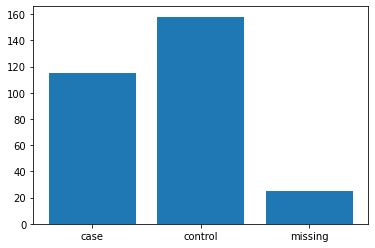

In [335]:
countRemission(vienna_fam_MTX)

## SERA

In [20]:
loc_list

['./Pipelinerun_withPC/RAMS/mergedChr/RAMS_merged.fam',
 './Pipelinerun_withPC/TwoCompDAS/Vienna_merged_sDAI.fam',
 './Pipelinerun_withPC/TwoCompDAS/RAMS_merged_2cDAS.fam',
 './Pipelinerun_withPC/TwoCompDAS/Vienna_merged_cDAI.fam',
 './Pipelinerun_withPC/TwoCompDAS/Vienna_merged_2cDAS.fam',
 './Pipelinerun_withPC/Madrid/mergedChr/madrid_merged.fam',
 './Pipelinerun_withPC/Manchester/mergedChr/Manchester_merged.fam',
 './Pipelinerun_withPC/Tacera/Final_imputed/TACERA_HRCv1_1_FINAL.fam',
 './Pipelinerun_withPC/EARTH_B/mergedChr/EARTH_setB_merged.fam',
 './Pipelinerun_withPC/EIRA/mergedChr/EIRA_merged.fam',
 './Pipelinerun_withPC/Glasgow/mergedChr/Glasgow_merged.fam',
 './Pipelinerun_withPC/ACPA/mergedChr/ACPAneg_merged.fam',
 './Pipelinerun_withPC/ACPA/mergedChr/ACPAneg_merged_overlapsToRemove.fam',
 './Pipelinerun_withPC/SERA/mergedChr/sera_merged.fam',
 './Pipelinerun_withPC/EARTH_A/mergedChr/EA127genotypes_merged.fam',
 './Pipelinerun_withPC/PEAC/mergedChr/PEAC_merged.fam',
 './Pipeli

In [253]:
SERA_fam = pd.read_csv(loc_list_MTX[5],sep='\s',header=None)
SERA_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,1_215284670,1_215284670,0,0,0,-9
1,100_215285060,100_215285060,0,0,0,1
2,1005_215284880,1005_215284880,0,0,0,2
3,1006_215293700,1006_215293700,0,0,0,-9
4,1007_215287480,1007_215287480,0,0,0,-9
...,...,...,...,...,...,...
663,984_215294600,984_215294600,0,0,0,2
664,985_215299420,985_215299420,0,0,0,2
665,986_215294170,986_215294170,0,0,0,2
666,987_215292670,987_215292670,0,0,0,-9


In [265]:
search_folder("/exports/reum/knevel_lab/SERA/Data/")

openning file  webEmploy.CSV


100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 59918.63it/s]


openning file  webSteroidInj.CSV


100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 90307.98it/s]


openning file  .DS_Store


0it [00:00, ?it/s]


openning file  DobGender.CSV


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 57456.22it/s]


openning file  webDiagnosis.CSV


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 58798.65it/s]


openning file  webJointFindings.CSV


100%|████████████████████████████████████████| 13/13 [00:00<00:00, 89533.58it/s]


Found pattern sjc in column num 7 sjc28
openning file  webConMed.CSV


100%|███████████████████████████████████████| 16/16 [00:00<00:00, 153919.41it/s]


openning file  webReferral.CSV


100%|████████████████████████████████████████| 16/16 [00:00<00:00, 98400.09it/s]


Found pattern mtx in column num 13 mtxTreatment
openning file  webCalcs.CSV


100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 50432.51it/s]


Found pattern crp in column num 5 DAS28CRP
openning file  webSwollenJnts.CSV


100%|███████████████████████████████████████| 42/42 [00:00<00:00, 216946.76it/s]


openning file  SERA Final Leiden Manifest.xlsx


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 77961.04it/s]


openning file  webTenderJnts.CSV


100%|███████████████████████████████████████| 42/42 [00:00<00:00, 202019.23it/s]


openning file  webDemog.CSV


100%|███████████████████████████████████████| 11/11 [00:00<00:00, 127804.28it/s]


openning file  Leiden Manifest 14 December 20.xlsx


100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 78643.20it/s]


openning file  webDisease.CSV


100%|████████████████████████████████████████| 34/34 [00:00<00:00, 27918.23it/s]

Found pattern crp in column num 4 CRP
Found pattern crp in column num 19 IsCRPDoneYN
Found pattern crp in column num 24 CRPFigureOperator
Found pattern crp in column num 29 CRPNAYN


[[],
 [],
 [],
 [],
 [],
 ['sjc28'],
 [],
 ['mtxTreatment'],
 ['DAS28CRP'],
 [],
 [],
 [],
 [],
 [],
 ['CRP', 'IsCRPDoneYN', 'CRPFigureOperator', 'CRPNAYN']]

In [267]:
web_referral = openfile("/exports/reum/knevel_lab/SERA/Data/webReferral.CSV")
web_referral

,ReferralSNo,OnsetD,OnsetM,OnsetY,ReferralD,ReferralM,ReferralY,FstOPDAppD,FstOPDAppM,FstOPDAppY,AssessmentD,AssessmentM,AssessmentY,mtxTreatment,IsReflDateKnownYN,IsOPDDateKnownYN
0,100,1,7,2010,22.0,2.0,2011.0,3.0,3.0,2011.0,3,3,2011,Yes,Yes,Yes
1,101,1,7,2010,21.0,1.0,2011.0,31.0,1.0,2011.0,16,3,2011,Yes,Yes,Yes
2,102,1,5,2010,13.0,1.0,2011.0,8.0,3.0,2011.0,24,3,2011,Yes,Yes,Yes
3,103,1,12,2010,7.0,2.0,2011.0,23.0,3.0,2011.0,28,3,2011,No,Yes,Yes
4,104,1,12,2010,4.0,3.0,2011.0,11.0,4.0,2011.0,14,4,2011,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,1315,1,11,2014,24.0,2.0,2015.0,5.0,3.0,2015.0,1,4,2015,Yes,Yes,Yes
1048,1316,1,3,2014,14.0,12.0,2014.0,15.0,12.0,2014.0,7,4,2015,Yes,Yes,Yes
1049,1317,1,8,2014,12.0,1.0,2015.0,19.0,1.0,2015.0,13,4,2015,No,Yes,Yes
1050,1318,2,11,2014,28.0,11.0,2014.0,22.0,12.0,2014.0,16,4,2015,Yes,Yes,Yes


In [294]:
web_referral['onset'] = web_referral['OnsetD'].map(str)+"-"+web_referral['OnsetM'].map(str)+"-"+web_referral['OnsetY'].map(str)
web_referral['onset'] = web_referral['onset'].map(todatetime)
web_referral['referral'] = web_referral['ReferralD'].map(str).str.replace('.0','')+"-"+web_referral['ReferralM'].map(str).str.replace('.0','')+"-"+web_referral['ReferralY'].map(str).str.replace('.0','')
web_referral['referral'] = web_referral['referral'].map(todatetime)

/tmp/ipykernel_2371238/3918106528.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  web_referral['referral'] = web_referral['ReferralD'].map(str).str.replace('.0','')+"-"+web_referral['ReferralM'].map(str).str.replace('.0','')+"-"+web_referral['ReferralY'].map(str).str.replace('.0','')
/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


In [295]:
web_referral

,ReferralSNo,OnsetD,OnsetM,OnsetY,ReferralD,ReferralM,ReferralY,FstOPDAppD,FstOPDAppM,FstOPDAppY,AssessmentD,AssessmentM,AssessmentY,mtxTreatment,IsReflDateKnownYN,IsOPDDateKnownYN,onset,referral
0,100,1,7,2010,22.0,2.0,2011.0,3.0,3.0,2011.0,3,3,2011,Yes,Yes,Yes,2010-01-07,2011-02-22
1,101,1,7,2010,21.0,1.0,2011.0,31.0,1.0,2011.0,16,3,2011,Yes,Yes,Yes,2010-01-07,2011-01-21
2,102,1,5,2010,13.0,1.0,2011.0,8.0,3.0,2011.0,24,3,2011,Yes,Yes,Yes,2010-01-05,2011-01-13
3,103,1,12,2010,7.0,2.0,2011.0,23.0,3.0,2011.0,28,3,2011,No,Yes,Yes,2010-01-12,2011-07-02
4,104,1,12,2010,4.0,3.0,2011.0,11.0,4.0,2011.0,14,4,2011,Yes,Yes,Yes,2010-01-12,2011-04-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,1315,1,11,2014,24.0,2.0,2015.0,5.0,3.0,2015.0,1,4,2015,Yes,Yes,Yes,2014-01-11,2015-02-24
1048,1316,1,3,2014,14.0,12.0,2014.0,15.0,12.0,2014.0,7,4,2015,Yes,Yes,Yes,2014-01-03,2014-12-14
1049,1317,1,8,2014,12.0,1.0,2015.0,19.0,1.0,2015.0,13,4,2015,No,Yes,Yes,2014-01-08,2015-12-01
1050,1318,2,11,2014,28.0,11.0,2014.0,22.0,12.0,2014.0,16,4,2015,Yes,Yes,Yes,2014-02-11,2014-11-28


In [300]:
web_referral_MTX = web_referral[(web_referral['referral']-web_referral['onset']<=timedelta(180)) & (web_referral['mtxTreatment']=='Yes')]
web_referral_MTX

,ReferralSNo,OnsetD,OnsetM,OnsetY,ReferralD,ReferralM,ReferralY,FstOPDAppD,FstOPDAppM,FstOPDAppY,AssessmentD,AssessmentM,AssessmentY,mtxTreatment,IsReflDateKnownYN,IsOPDDateKnownYN,onset,referral
6,106,1,2,2011,6.0,4.0,2011.0,21.0,4.0,2011.0,28,4,2011,Yes,Yes,Yes,2011-01-02,2011-06-04
9,109,1,4,2011,3.0,5.0,2011.0,30.0,5.0,2011.0,30,5,2011,Yes,Yes,Yes,2011-01-04,2011-03-05
12,112,3,2,2011,3.0,5.0,2011.0,7.0,6.0,2011.0,15,6,2011,Yes,Yes,Yes,2011-03-02,2011-03-05
14,114,18,1,2011,19.0,5.0,2011.0,15.0,6.0,2011.0,15,6,2011,Yes,Yes,Yes,2011-01-18,2011-05-19
16,116,31,3,2011,19.0,5.0,2011.0,14.0,6.0,2011.0,23,6,2011,Yes,Yes,Yes,2011-03-31,2011-05-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,1293,1,10,2014,1.0,11.0,2014.0,10.0,12.0,2014.0,10,12,2014,Yes,Yes,Yes,2014-01-10,2014-01-11
1032,1299,24,7,2014,14.0,8.0,2014.0,21.0,8.0,2014.0,21,1,2015,Yes,Yes,Yes,2014-07-24,2014-08-14
1034,1301,14,12,2014,23.0,12.0,2014.0,22.0,1.0,2015.0,17,2,2015,Yes,Yes,Yes,2014-12-14,2014-12-23
1042,1310,16,12,2014,19.0,12.0,2014.0,12.0,2.0,2015.0,16,3,2015,Yes,Yes,Yes,2014-12-16,2014-12-19


In [88]:
def processdcID(row):
    row = str(row).replace(" ","").lstrip("0")
    return row
def processFAM(row):
    row = str(row).split("_")[1]
    return row

In [303]:
SERA_pheno = openfile("/exports/reum/knevel_lab/SERA/Data/SERA Final Leiden Manifest.xlsx",n=2)
SERA_pheno['ID'] = SERA_pheno['dcID'].map(processdcID)
SERA_pheno

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,StudyNo,Location,dcID,Barcode original,Plate,ID
0,434,"(1, 1)",02 1528731 0,NTBJ386054,74501.0,215287310
1,625,"(1, 10)",02 1528740 0,NTBJ391302,74501.0,215287400
2,517,"(1, 11)",02 1528741 0,NTBJ385994,74501.0,215287410
3,419,"(1, 12)",02 1528742 0,NTBJ386203,74501.0,215287420
4,533,"(1, 4)",02 1528734 0,NTBJ386522,74501.0,215287340
...,...,...,...,...,...,...
691,226,"(6, 9)",02 1529866 0,E0000000102,74514.0,215298660
692,326,"(6, 10)",02 1529867 0,E0000000459,74514.0,215298670
693,230,"(6, 11)",02 1529868 0,E0000000219,74514.0,215298680
694,286,"(6, 12)",02 1528752 0,E0000000704,74514.0,215287520


In [307]:
SERA_pheno_MTX = SERA_pheno[SERA_pheno['StudyNo'].isin(web_referral_MTX['ReferralSNo'])]
SERA_pheno_MTX

,StudyNo,Location,dcID,Barcode original,Plate,ID
6,431,"(1, 6)",02 1528736 0,NTBJ385684,74501.0,215287360
7,355,"(1, 7)",02 1528737 0,NTBJ389732,74501.0,215287370
22,332,"(4, 6)",02 1528774 0,NTBJ389839,74501.0,215287740
23,397,"(4, 7)",02 1528779 0,NTBJ388405,74501.0,215287790
27,478,"(5, 1)",02 1528783 0,NTBJ385693,74501.0,215287830
...,...,...,...,...,...,...
681,1094,"(5, 10)",02 1529454 0,E0000001855,74514.0,215294540
683,1202,"(5, 12)",02 1529456 0,E0000002496,74514.0,215294560
684,1220,"(6, 1)",02 1529457 0,E0000002494,74514.0,215294570
686,1158,"(6, 4)",02 1529460 0,E0000002263,74514.0,215294600


In [304]:
SERA_fam['ID'] = SERA_fam[0].map(processFAM)
SERA_fam

,0,1,2,3,4,5,ID
0,1_215284670,1_215284670,0,0,0,-9,215284670
1,100_215285060,100_215285060,0,0,0,1,215285060
2,1005_215284880,1005_215284880,0,0,0,2,215284880
3,1006_215293700,1006_215293700,0,0,0,-9,215293700
4,1007_215287480,1007_215287480,0,0,0,-9,215287480
...,...,...,...,...,...,...,...
663,984_215294600,984_215294600,0,0,0,2,215294600
664,985_215299420,985_215299420,0,0,0,2,215299420
665,986_215294170,986_215294170,0,0,0,2,215294170
666,987_215292670,987_215292670,0,0,0,-9,215292670


In [310]:
SERA_fam_MTX = pd.merge(SERA_fam,SERA_pheno_MTX,how='inner',on="ID").loc[:,[0,1,2,3,4,5]]
SERA_fam_MTX

,0,1,2,3,4,5
0,1005_215284880,1005_215284880,0,0,0,2
1,102_215286340,102_215286340,0,0,0,1
2,1038_215292680,1038_215292680,0,0,0,1
3,1055_215298930,1055_215298930,0,0,0,1
4,1058_215287290,1058_215287290,0,0,0,2
...,...,...,...,...,...,...
130,815_215298570,815_215298570,0,0,0,-9
131,842_215292650,842_215292650,0,0,0,-9
132,915_215293240,915_215293240,0,0,0,-9
133,962_215292310,962_215292310,0,0,0,2


In [311]:
#135 samples
SERA_fam_MTX.to_csv("/exports/reum/CKe/Pipelinerun_withPC/MTXsubset/SERA_merged_MTX.fam",sep='\t',index=False,header=False)

(42, 47, 46)

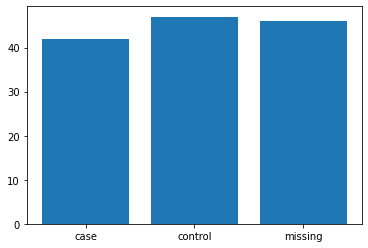

In [336]:
countRemission(SERA_fam_MTX)

## SERA2-GLASGOW

In [8]:
SERA2_fam = pd.read_csv("/exports/reum/CKe/Pipelinerun_withPC/Glasgow/mergedChr/Glasgow_merged.fam",sep='\s',header=None)
SERA2_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,3_215289020,3_215289020,0,0,1,1
1,4_215285720,4_215285720,0,0,1,2
2,5_215287570,5_215287570,0,0,0,-9
3,6_215286070,6_215286070,0,0,2,2
4,10_215286430,10_215286430,0,0,1,2
...,...,...,...,...,...,...
339,568_215288500,568_215288500,0,0,2,1
340,569_215291730,569_215291730,0,0,2,1
341,572_215286600,572_215286600,0,0,2,1
342,574_215285670,574_215285670,0,0,2,2


In [89]:
SERA2_fam['ID'] = SERA2_fam[0].map(processFAM)
SERA2_fam

,0,1,2,3,4,5,ID
0,3_215289020,3_215289020,0,0,1,1,215289020
1,4_215285720,4_215285720,0,0,1,2,215285720
2,5_215287570,5_215287570,0,0,0,-9,215287570
3,6_215286070,6_215286070,0,0,2,2,215286070
4,10_215286430,10_215286430,0,0,1,2,215286430
...,...,...,...,...,...,...,...
339,568_215288500,568_215288500,0,0,2,1,215288500
340,569_215291730,569_215291730,0,0,2,1,215291730
341,572_215286600,572_215286600,0,0,2,1,215286600
342,574_215285670,574_215285670,0,0,2,2,215285670


In [90]:
SERA2_pheno = openfile("/exports/reum/knevel_lab/SERA/Data/Leiden Manifest 14 December 20.xlsx")
SERA2_pheno['ID'] = SERA2_pheno['dcID'].map(processdcID)
SERA2_pheno

,Box Number,StudyNo,dcID,Barcode original,Updated location,Scanned barcode,ID
0,Box 1 SERA Decode DNA,206,02 1528607 0,NTBI991424,A1,NaN,215286070
1,Box 1 SERA Decode DNA,179,02 1528608 0,NUFY858106,A2,NaN,215286080
2,Box 1 SERA Decode DNA,154,02 1528609 0,NUFY853350,A3,NaN,215286090
3,Box 1 SERA Decode DNA,139,02 1528610 0,NUFY851945,A4,NaN,215286100
4,Box 1 SERA Decode DNA,120,02 1528611 0,NUFY850894,A5,NaN,215286110
...,...,...,...,...,...,...,...
338,74505,453,02 1529086 0,NTBI997002,"(7, 2)",NaN,215290860
339,74505,403,02 1529087 0,NTBI981782,"(7, 3)",NaN,215290870
340,74505,457,02 1529088 0,NTBI997491,"(7, 4)",NaN,215290880
341,74505,327,02 1529089 0,NTBI989137,"(7, 5)",NaN,215290890


In [91]:
SERA2_pheno_MTX = SERA2_pheno[SERA2_pheno['StudyNo'].isin(web_referral_MTX['ReferralSNo'])]
SERA2_pheno_MTX

NameError: name 'web_referral_MTX' is not defined

In [325]:
SERA2_fam_MTX = pd.merge(SERA2_fam,SERA2_pheno_MTX,how='inner',on="ID").loc[:,[0,1,2,3,4,5]]
SERA2_fam_MTX

,0,1,2,3,4,5
0,3_215289020,3_215289020,0,0,1.0,1.0
1,4_215285720,4_215285720,0,0,1.0,2.0
2,10_215286430,10_215286430,0,0,1.0,2.0
3,18_215286320,18_215286320,0,0,2.0,1.0
4,21_215287100,21_215287100,0,0,2.0,1.0
...,...,...,...,...,...,...
99,561_215285950,561_215285950,0,0,1.0,1.0
100,562_215288070,562_215288070,0,0,2.0,2.0
101,565_215290820,565_215290820,0,0,1.0,2.0
102,569_215291730,569_215291730,0,0,2.0,1.0


In [96]:
# 104 samples
SERA2_fam_MTX.to_csv("/exports/reum/CKe/Pipelinerun_withPC/MTXsubset/Glasgow_merged_MTX.fam",sep='\t',index=False,header=False)

(43, 55, 6)

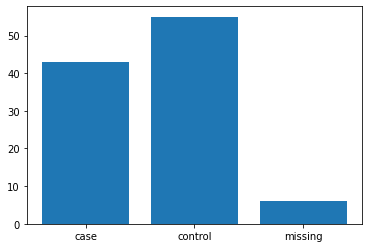

In [97]:
countRemission(SERA2_fam_MTX)

In [93]:
SERA2_fam_MTX = pd.read_csv("/exports/reum/CKe/Pipelinerun_withPC/MTXsubset/Glasgow_merged_MTX.fam",sep='\t',header=None)
SERA2_fam_MTX

,0,1,2,3,4,5
0,3_215289020,3_215289020,0,0,1.0,1.0
1,4_215285720,4_215285720,0,0,1.0,2.0
2,10_215286430,10_215286430,0,0,1.0,2.0
3,18_215286320,18_215286320,0,0,2.0,1.0
4,21_215287100,21_215287100,0,0,2.0,1.0
...,...,...,...,...,...,...
99,561_215285950,561_215285950,0,0,1.0,1.0
100,562_215288070,562_215288070,0,0,2.0,2.0
101,565_215290820,565_215290820,0,0,1.0,2.0
102,569_215291730,569_215291730,0,0,2.0,1.0


In [94]:
#change float in columns to int
SERA2_fam_MTX[4] = SERA2_fam_MTX[4].astype(int)
SERA2_fam_MTX[5] = SERA2_fam_MTX[5].astype(int)

In [95]:
SERA2_fam_MTX

,0,1,2,3,4,5
0,3_215289020,3_215289020,0,0,1,1
1,4_215285720,4_215285720,0,0,1,2
2,10_215286430,10_215286430,0,0,1,2
3,18_215286320,18_215286320,0,0,2,1
4,21_215287100,21_215287100,0,0,2,1
...,...,...,...,...,...,...
99,561_215285950,561_215285950,0,0,1,1
100,562_215288070,562_215288070,0,0,2,2
101,565_215290820,565_215290820,0,0,1,2
102,569_215291730,569_215291730,0,0,2,1


## Tacera

In [366]:
Tacera = openfile("/exports/reum/CKe/Tacera/RA-MAP_data_clinical.csv")
keyfile = openfile("/exports/reum/CKe/Tacera/OpenPseudonymised_RA-MAP DNA_IDs deidentified to date 02Dec16_with_HLA.xlsx")
Tacera_fam = pd.read_csv("/exports/reum/CKe/Pipelinerun_withPC/Tacera/Final_imputed/TACERA_HRCv1_1_FINAL.fam",sep='\s',header=None)

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [340]:
search(Tacera.columns)

100%|██████████████████████████████████████| 300/300 [00:00<00:00, 34814.24it/s]

Found pattern crp in column num 27 \RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\CRP Value (mg/L) 00BL\
Found pattern crp in column num 39 \RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\DAS-28 CRP 00BL\
Found pattern sdai in column num 46 \RAMAP\RAMAP\Clinical Data\00 Baseline\SDAI\SDAI <= 3.3 00BL\
Found pattern sdai in column num 47 \RAMAP\RAMAP\Clinical Data\00 Baseline\SDAI\SDAI score 00BL\
Found pattern crp in column num 48 \RAMAP\RAMAP\Clinical Data\03 Months\DAS\Components\CRP Value (mg/L) 03M\
Found pattern crp in column num 60 \RAMAP\RAMAP\Clinical Data\03 Months\DAS\DAS-28 CRP 03M\
Found pattern sdai in column num 64 \RAMAP\RAMAP\Clinical Data\03 Months\SDAI\SDAI <= 3.3 03M\
Found pattern sdai in column num 65 \RAMAP\RAMAP\Clinical Data\03 Months\SDAI\SDAI score 03M\
Found pattern crp in column num 77 \RAMAP\RAMAP\Clinical Data\06 Months\DAS\Components\CRP Value (mg/L) 06M\
Found pattern crp in column num 89 \RAMAP\RAMAP\Clinical Data\06 Months\DAS\DAS-28 CRP 06M\
Found p

['\\RAMAP\\RAMAP\\Clinical Data\\00 Baseline\\DAS\\Components\\CRP Value (mg/L) 00BL\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\00 Baseline\\DAS\\DAS-28 CRP 00BL\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\00 Baseline\\SDAI\\SDAI <= 3.3 00BL\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\00 Baseline\\SDAI\\SDAI score 00BL\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\03 Months\\DAS\\Components\\CRP Value (mg/L) 03M\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\03 Months\\DAS\\DAS-28 CRP 03M\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\03 Months\\SDAI\\SDAI <= 3.3 03M\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\03 Months\\SDAI\\SDAI score 03M\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\06 Months\\DAS\\Components\\CRP Value (mg/L) 06M\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\06 Months\\DAS\\DAS-28 CRP 06M\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\06 Months\\SDAI\\SDAI <= 3.3 06M\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\06 Months\\SDAI\\SDAI score 06M\\',
 '\\RAMAP\\RAMAP\\Clinical Data\\09 Months\\DAS\\Components\\CRP Value (mg/L) 09M\\',
 '\\RAMAP\\RAMAP\\Clini

In [347]:
keyfile

,Digest,sample_id,Study,notes,sample_id.1,HLA_A_1,HLA_B_1,HLA_C_1,HLA_DPA1_1,HLA_DPB1_1,HLA_DRB1_1,HLA_DQA1_1,HLA_DQB1_1,HLA_A_2,HLA_B_2,HLA_C_2,HLA_DPA1_2,HLA_DPB1_2,HLA_DRB1_2,HLA_DQA1_2,HLA_DQB1_2
0,D3A02019792FDA6C8C6B9CA21512801610FB7176BAE732...,D-21781-1,RAMAP-tacera,exclude: duplicate subject IDs but genotypes d...,D-21781-1,3201,5501,303,103,401,401,301,302,301,1518,704,103,201,1101,501,301
1,D3A02019792FDA6C8C6B9CA21512801610FB7176BAE732...,D-21863-1,RAMAP-tacera,exclude: duplicate subject IDs but genotypes d...,D-21863-1,301,5701,602,201,1301,701,201,303,201,702,702,103,402,1103,501,301
2,NaN,D-21919-1,RAMAP-tacera,exclude: subjects unknown,D-21919-1,101,5701,602,201,1001,1501,102,602,201,1501,303,103,401,401,301,302
3,NaN,D-21955-1,RAMAP-tacera,exclude: subjects unknown,D-21955-1,2301,4403,401,103,201,701,201,202,301,1501,102,201,1001,101,101,501
4,NaN,D-22960-1,RAMAP-tacera,exclude: subjects unknown,D-22960-1,1101,3501,401,201,101,101,101,501,101,702,702,103,401,1101,501,301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,F77FCE78B9C12C4011E3C22AC81BD7EA93519F47769081...,D-23010-1,Vaccine,NaN,D-23010-1,201,4402,704,103,401,101,101,501,301,702,702,103,601,1501,102,602
291,E09DBC4609157185B2C8110022C52378534EAEFA20BA83...,D-33052-1,Vaccine,NaN,D-33052-1,6801,702,702,103,401,1501,102,602,1101,5601,102,201,1101,701,201,202
292,335879869F16C038AE5E619D36C979021B7D761AC80B84...,Z-21686-1,RAMAP-tacera,NaN,Z-21686-1,1101,4001,304,103,201,1501,102,502,2402,1301,304,103,401,1501,102,601
293,BF9D48FEB435B3F585DDDBF5D966C024E2027C62F82C48...,Z-21746-1,RAMAP-tacera,NaN,Z-21746-1,301,3501,401,103,401,401,301,301,1101,5101,1502,103,601,404,301,302


In [345]:
Tacera

,Subject ID,\RAMAP\RAMAP\Clinical Data\.ACPA/RF Eligibility\ACPA\ACPA Unit\,\RAMAP\RAMAP\Clinical Data\.ACPA/RF Eligibility\ACPA\ACPA Value\,\RAMAP\RAMAP\Clinical Data\.ACPA/RF Eligibility\ACPA\ACPA positive\,\RAMAP\RAMAP\Clinical Data\.ACPA/RF Eligibility\Rheumatoid Factor\RF Unit\,\RAMAP\RAMAP\Clinical Data\.ACPA/RF Eligibility\Rheumatoid Factor\RF Value\,\RAMAP\RAMAP\Clinical Data\.ACPA/RF Eligibility\Rheumatoid Factor\Rheum Factor positive\,\RAMAP\RAMAP\Clinical Data\.Screening\ACPA\ACPA Unit SCR\,\RAMAP\RAMAP\Clinical Data\.Screening\ACPA\ACPA Value SCR\,\RAMAP\RAMAP\Clinical Data\.Screening\ACPA\ACPA positive SCR\,\RAMAP\RAMAP\Clinical Data\.Screening\Rheumatoid Factor\RF Unit SCR\,\RAMAP\RAMAP\Clinical Data\.Screening\Rheumatoid Factor\RF Value SCR\,\RAMAP\RAMAP\Clinical Data\.Screening\Rheumatoid Factor\Rheum Factor positive SCR\,\RAMAP\RAMAP\Clinical Data\00 Baseline\ACPA\ACPA Unit 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\ACPA\ACPA Value 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\ACPA\ACPA positive 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Blood count\Basophils 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Blood count\Date of FBC 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Blood count\Eosinophils 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Blood count\GL 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Blood count\Gdl 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Blood count\HB 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Blood count\Lymphocytes 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Blood count\Monocytes 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Blood count\Neutrophils 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Blood count\PLT 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Blood count\WBC 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\CRP Value (mg/L) 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\ESR Value 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\Evaluator global 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\Fatique 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\Outside 2 week window 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\Pain score 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\Patient global 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\Total 66/68 Swollen Joints 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\Total 66/68 Tender Joints 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\Total Swollen 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\Total Tender 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\Components\Use of sign '<' 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\DAS-28 CRP 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\DAS28 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\DAS\DAS28 relative 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\HAQ\Metrologist's score 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Rheumatoid Factor\RF Unit 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Rheumatoid Factor\RF Value 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\Rheumatoid Factor\Rheum Factor positive 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\SDAI\SDAI <= 3.3 00BL\,\RAMAP\RAMAP\Clinical Data\00 Baseline\SDAI\SDAI score 00BL\,\RAMAP\RAMAP\Clinical Data\03 Months\DAS\Components\CRP Value (mg/L) 03M\,\RAMAP\RAMAP\Clinical Data\03 Months\DAS\Components\ESR Value 03M\,\RAMAP\RAMAP\Clinical Data\03 Months\DAS\Components\Evaluator global 03M\,\RAMAP\RAMAP\Clinical Data\03 Months\DAS\Components\Fatique 03M\,\RAMAP\RAMAP\Clinical Data\03 Months\DAS\Components\Outside 2 week window 03M\,\RAMAP\RAMAP\Clinical Data\03 Months\DAS\Components\Pain score 03M\,\RAMAP\RAMAP\Clinical Data\03 Months\DAS\Components\Patient global 03M\,\RAMAP\RAMAP\Clinical Data\03 Months\DAS\Components\Total 66/68 Swollen Joints 03M\,\RAMAP\RAMAP\Clinical Data\03 Months\DAS\Components\Total 66/68 Tender Joints 03M\,\RAMAP\RAMAP\Clinical Data\03 Months\DAS\Components\Total Swollen 03M\,

In [349]:
Tacera = Tacera.merge(keyfile,how='left',left_on="Subject ID",right_on='Digest')

In [359]:
Tacera_MTX = Tacera.loc[:,['sample_id','\\RAMAP\\RAMAP\\Medication\\00 Baseline\\Methotrexate 00BL\\',
 '\\RAMAP\\RAMAP\\Medication\\03 Months\\Methotrexate 03M\\',
 '\\RAMAP\\RAMAP\\Medication\\06 Months\\Methotrexate 06M\\',]]
Tacera_MTX = Tacera_MTX[(Tacera_MTX['\\RAMAP\\RAMAP\\Medication\\00 Baseline\\Methotrexate 00BL\\']=='Yes') | (Tacera_MTX['\\RAMAP\\RAMAP\\Medication\\03 Months\\Methotrexate 03M\\']=='Yes') | (Tacera_MTX['\\RAMAP\\RAMAP\\Medication\\06 Months\\Methotrexate 06M\\']=='Yes')]
Tacera_MTX

,sample_id,\RAMAP\RAMAP\Medication\00 Baseline\Methotrexate 00BL\,\RAMAP\RAMAP\Medication\03 Months\Methotrexate 03M\,\RAMAP\RAMAP\Medication\06 Months\Methotrexate 06M\
0,D-21688-1,No,Yes,NaN
1,D-21679-1,Yes,Yes,Yes
2,D-21683-1,Yes,Yes,Yes
3,D-21671-1,Yes,Yes,NaN
4,D-21673-1,NaN,NaN,Yes
...,...,...,...,...
266,D-21763-1,Yes,Yes,Yes
267,D-21760-1,Yes,Yes,Yes
268,D-21758-1,Yes,Yes,Yes
269,D-21944-1,Yes,Yes,Yes


In [370]:
Tacera_fam['id'] = Tacera_fam[0].str.split("_",expand=True)[0]
Tacera_fam_MTX = pd.merge(Tacera_fam,Tacera_MTX,how='inner',left_on='id',right_on='sample_id').loc[:,[0,1,2,3,4,5]]
Tacera_fam_MTX

,0,1,2,3,4,5
0,D-21657-1_D-21657-1,D-21657-1_D-21657-1,0,0,1,1
1,D-21659-1_D-21659-1,D-21659-1_D-21659-1,0,0,2,2
2,D-21660-1_D-21660-1,D-21660-1_D-21660-1,0,0,2,1
3,D-21661-1_D-21661-1,D-21661-1_D-21661-1,0,0,2,1
4,D-21662-1_D-21662-1,D-21662-1_D-21662-1,0,0,2,1
...,...,...,...,...,...,...
216,D-21949-1_D-21949-1,D-21949-1_D-21949-1,0,0,2,1
217,D-21950-1_D-21950-1,D-21950-1_D-21950-1,0,0,2,1
218,Z-21686-1_Z-21686-1,Z-21686-1_Z-21686-1,0,0,2,1
219,Z-21746-1_Z-21746-1,Z-21746-1_Z-21746-1,0,0,2,1


In [371]:
#221 samples
Tacera_fam_MTX.to_csv("/exports/reum/CKe/Pipelinerun_withPC/MTXsubset/Tacera_merged_MTX.fam",sep='\t',index=False,header=False)

(75, 127, 19)

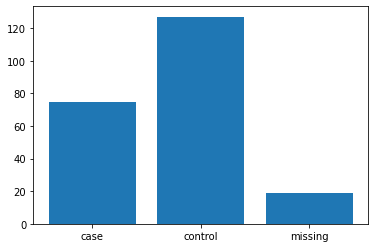

In [372]:
countRemission(Tacera_fam_MTX)

In [42]:
#EAC
EAC_medical = openfile("/exports/reum/knevel_lab/EAC_PatDat/MedicatieVoorschrift_EAC.csv",sep='|')
EAC_medical

/tmp/ipykernel_2939765/930533549.py:2: DtypeWarning: Columns (3,10,11,26) have mixed types.Specify dtype option on import or set low_memory=False.
  EAC_medical = openfile("/exports/reum/knevel_lab/EAC_PatDat/MedicatieVoorschrift_EAC.csv",sep='|')


,VoorschriftID,VoorschriftBron,PseudoID,MedicatieProductID,VoorschrijverID,VoorschrijverNaam,Voorschrijftype,VoorschriftDatumTijd,SchemaOmschrijving,VoorschriftMedicatieStatusCode,VoorschriftRedenVanStoppen,VoorschriftRedenVanOnderbreken,VoorschriftGroepscode,SchemaStartdag,SchemaStartDatumtijd,SchemaEindDatumtijd,SchemaGebruiksduur_Waarde,Gebruiksduur_Eenheid,SchemaFrequentie_Waarde,frequentie_Eenheid,SchemaInterval_Waarde,interval_Eenheid,SchemaZonodig,IndicatieDuurGeneesmiddelCode,ZiekenhuisCode,IndicatieDuurGeneesmiddelOmschrijving,toedieningsHoeveelheid,toedieningsHoeveelheidEenheid,MedicatieKNMPNummer,MedicatieATCCode,MedicatieHPKCode,MedicatiePRKCode,MedicatieGPKCode,MedicatieGPKOmschrijving,MedicatieProductNaam,MedicatieFarmaceutischeVorm,ToedieningsCode,ToedieningsOmschrijving,VoorschriftAfdeling,patient_id
0,13691225,HIX,1237358,0000172181,P32767,D Mohabati,Poliklinisch,2019-04-06 00:00:00,3 x per dag 1 druppel,NaN,NaN,NaN,NaN,1,2019-04-06 00:00:00,None,0.0,None,3.0,D,0.0,None,False,None,None,None,1.0,Druppel,NaN,S01EA03,NaN,43273.0,97101.0,APRACLONIDINE,APRACLONIDINE OOGDRUPPELS 5MG/ML FL 5ML,0,999943,"OOG,LINKS",NaN,5408011
1,13691115,HIX,1314385,0000169477,S01000,Traumatologie,Klinisch,2019-04-06 00:00:00,1 x per dag 10 milligram [adhoc],NaN,NaN,NaN,NaN,1,2019-04-06 08:29:00,2019-04-06 08:29:00,0.0,None,1.0,D,0.0,None,False,None,None,None,10.0,Milligram,NaN,A03FA01,NaN,108.0,71706.0,METOCLOPRAMIDE,METOCLOPRAMIDE INJVLST 5MG/ML (HCL) AMP 2ML,0,5,IV,NaN,5968050
2,13691087,HIX,1314385,0000629699,AB5057,R Blanken,Geïmporteerd / Conversie,2018-11-27 00:00:00,1 x per dag 1 stuk,NaN,NaN,NaN,NaN,1,2018-11-27 00:00:00,2019-03-13 00:00:00,106.0,D,1.0,D,0.0,None,False,None,None,None,1.0,Stuk,16031962.0,H03AA01,636940.0,30171.0,77801.0,LEVOTHYROXINE,"THYRAX DUOTAB TABLET 0,150MG",0,9,ORAAL,NaN,5968050
3,13691086,HIX,1314385,0000595431,AB5057,R Blanken,Geïmporteerd / Conversie,2018-11-27 00:00:00,1 x per dag 1 stuk,NaN,NaN,NaN,NaN,1,2018-11-27 00:00:00,2019-03-13 00:00:00,106.0,D,1.0,D,0.0,None,False,None,None,None,1.0,Stuk,15822761.0,N02BE01,2282321.0,81442.0,125822.0,PARACETAMOL,PARACETAMOL SANDOZ TABLET 1000MG,0,9,ORAAL,NaN,5968050
4,13691085,HIX,1314385,0000557991,AB5057,R Blanken,Geïmporteerd / Conversie,2018-11-27 00:00:00,1 x per dag 1 stuk,NaN,NaN,NaN,NaN,1,2018-11-27 00:00:00,2019-03-13 00:00:00,106.0,D,1.0,D,0.0,None,False,None,None,None,1.0,Stuk,15638723.0,L04AA13,2143046.0,53619.0,109290.0,LEFLUNOMIDE,LEFLUNOMIDE SANDOZ TABLET FILMOMHULD 20MG,0,9,ORAAL,NaN,5968050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73297,75995,HIX,182742,8676,Chipsoft (Conversie),Chipsoft (Conversie),Geïmporteerd / Conversie,2011-03-30 00:00:00,1 x per dag 5 milligram,NaN,NaN,NaN,NaN,1,2011-03-30 00:00:00,None,0.0,None,1.0,D,0.0,None,False,None,None,None,5.0,Milligram,13921339.0,H02AB06,858102.0,30449.0,23809.0,PREDNISOLON,PREDNISOLON TEVA TABLET 5MG,0,9,ORAAL,NaN,74182
73298,75993,HIX,182742,25103,Chipsoft (Conversie),Chipsoft (Conversie),Geïmporteerd / Conversie,2011-03-30 00:00:00,Per week 15 milligram,NaN,NaN,NaN,NaN,1,2011-03-30 00:00:00,None,0.0,None,1.0,D,6.0,D,False,None,None,None,15.0,Milligram,14571013.0,L04AX03,1421778.0,141631.0,16918.0,METHOTREXAAT,"METHOTREXAAT PCH TABLET 2,5MG",0,9,ORAAL,NaN,74182
73299,75991,HIX,182742,8676,Chipsoft (Conversie),Chipsoft (Conversie),Geïmporteerd / Conversie,2011-03-30 00:00:00,1 x per dag 10 milligram,NaN,NaN,NaN,NaN,1,2011-03-30 00:00:00,None,0.0,None,1.0,D,0.0,None,False,None,None,None,10.0,Milligram,13921339.0,H02AB06,858102.0,30449.0,23809.0,PREDNISOLON,PREDNISOLON TEVA TABLET 5MG,0,9,ORAAL,NaN,74182
73300,75989,HIX,182742,81659,Chipsoft (Conversie),Chipsoft (Conversie),Geïmporteerd / Conversie,2011-03-23 00:00:00,1 x per dag 40 milligram,NaN,NaN,NaN,NaN,1,2011-03-23 00:00:00,None,0.0,None,1.0,D,0.0,None,False,None,None,None,40.0,Milligram,15460177.0,A02BC02,2002922.0,4

In [43]:
len(EAC_medical['patient_id'].unique())

903

In [21]:
EAC_NUMM_key = pd.read_csv("/exports/reum/knevel_lab/EAC_GSA/EAC_key_final_typed_samples.txt",sep="|")
EAC_NUMM_key

,EAC nummer,oud,Sample,MicroBarcode.2,Gerries nummer,Plate,Coordinate,Approximate ng,C=ng L,aantal L9,10,aantal L11,EACNUMM,geslacht
0,1002,1002,203,NaN,203,3,C2,855.0,171.0,5.0,NaN,NaN,NaN,1.0
1,1004,1004,342,NaN,342,4,F7,3375.0,675.0,5.0,NaN,NaN,NaN,1.0
2,1012,1012,108,NaN,108,2,D2,500.0,50.0,10.0,NaN,NaN,NaN,1.0
3,1018,1018,653,NaN,653,7,E10,1570.0,314.0,5.0,NaN,NaN,NaN,2.0
4,1020,1020,176,NaN,176,2,H10,350.0,70.0,5.0,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,990,990,563,NaN,563,6,C11,885.0,177.0,5.0,NaN,NaN,NaN,1.0
1035,not correct,not correct,125,NaN,125,2,E4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1036,not correct,not correct,131,NaN,131,2,C5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,not correct,not correct,118,NaN,118,2,F3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
EAC_medical[EAC_medical['SchemaStartDatumtijd']==max(EAC_medical['SchemaStartDatumtijd'])]

,VoorschriftID,VoorschriftBron,PseudoID,MedicatieProductID,VoorschrijverID,VoorschrijverNaam,Voorschrijftype,VoorschriftDatumTijd,SchemaOmschrijving,VoorschriftMedicatieStatusCode,VoorschriftRedenVanStoppen,VoorschriftRedenVanOnderbreken,VoorschriftGroepscode,SchemaStartdag,SchemaStartDatumtijd,SchemaEindDatumtijd,SchemaGebruiksduur_Waarde,Gebruiksduur_Eenheid,SchemaFrequentie_Waarde,frequentie_Eenheid,SchemaInterval_Waarde,interval_Eenheid,SchemaZonodig,IndicatieDuurGeneesmiddelCode,ZiekenhuisCode,IndicatieDuurGeneesmiddelOmschrijving,toedieningsHoeveelheid,toedieningsHoeveelheidEenheid,MedicatieKNMPNummer,MedicatieATCCode,MedicatieHPKCode,MedicatiePRKCode,MedicatieGPKCode,MedicatieGPKOmschrijving,MedicatieProductNaam,MedicatieFarmaceutischeVorm,ToedieningsCode,ToedieningsOmschrijving,VoorschriftAfdeling,patient_id
63640,1015562,HIX,1181746,169665,P31760,S Floor,Klinisch,2099-01-01 00:00:00,1 x per dag 1000 milligram,NaN,NaN,NaN,NaN,1,2099-01-01 00:00:00,2012-07-17 00:00:00,1.0,D,1.0,D,0.0,None,False,None,None,None,1000.0,Milligram,NaN,J01DB04,NaN,3263.0,16624.0,CEFAZOLINE,CEFAZOLINE PDR V INJVLST 1000MG FL,0,5,IV,VA02,5201710
66918,668208,HIX,556978,175209,P06800,Z de Jong - Strakova,Klinisch,2099-01-01 00:00:00,volgens afspraak 480 milligram,NaN,NaN,NaN,NaN,1,2099-01-01 00:00:00,2011-09-06 16:09:00,0.0,None,0.0,None,0.0,None,False,None,None,None,480.0,Milligram,NaN,L04AC07,NaN,89001.0,130796.0,TOCILIZUMAB,TOCILIZUMAB INFOPL CONC 20MG/ML FL 10ML,0,5,IV,C11Q,2013552
66919,668185,HIX,556978,175209,P06800,Z de Jong - Strakova,Klinisch,2099-01-01 00:00:00,volgens afspraak 480 milligram,NaN,NaN,NaN,NaN,1,2099-01-01 00:00:00,2011-09-06 16:08:00,0.0,None,0.0,None,0.0,None,False,None,None,None,480.0,Milligram,NaN,L04AC07,NaN,89001.0,130796.0,TOCILIZUMAB,TOCILIZUMAB INFOPL CONC 20MG/ML FL 10ML,0,5,IV,C11Q,2013552
66936,665748,HIX,556978,175209,P06800,Z de Jong - Strakova,Klinisch,2099-01-01 00:00:00,volgens afspraak 480 milligram,NaN,NaN,NaN,NaN,1,2099-01-01 00:00:00,2011-08-25 13:38:00,0.0,None,0.0,None,0.0,None,False,None,None,None,480.0,Milligram,NaN,L04AC07,NaN,89001.0,130796.0,TOCILIZUMAB,TOCILIZUMAB INFOPL CONC 20MG/ML FL 10ML,0,5,IV,C11Q,2013552
66937,665743,HIX,556978,175209,P06800,Z de Jong - Strakova,Klinisch,2099-01-01 00:00:00,volgens afspraak 480 milligram,NaN,NaN,NaN,NaN,1,2099-01-01 00:00:00,2011-08-25 13:38:00,0.0,None,0.0,None,0.0,None,False,None,None,None,480.0,Milligram,NaN,L04AC07,NaN,89001.0,130796.0,TOCILIZUMAB,TOCILIZUMAB INFOPL CONC 20MG/ML FL 10ML,0,5,IV,C11Q,2013552
67198,629446,HIX,1352772,175208,P06259,CF Allaart,Klinisch,2099-01-01 00:00:00,1 x per dag eenmalig 360 mg,NaN,NaN,NaN,NaN,1,2099-01-01 00:00:00,2011-08-04 17:37:00,0.0,None,1.0,D,0.0,None,False,None,None,None,0.0,Milligram,NaN,L04AC07,NaN,88994.0,130796.0,TOCILIZUMAB,TOCILIZUMAB INFOPL CONC 20MG/ML FL 4ML,0,5,IV,C11Q,6110525
67563,573854,HIX,1336386,104397,P28279,WMC Koenraadt,Klinisch,2099-01-01 00:00:00,2 x per dag 1 milligram,NaN,NaN,NaN,NaN,1,2099-01-01 00:00:00,2011-08-10 03:55:00,72.0,D,2.0,D,0.0,None,False,None,None,None,1.0,Milligram,NaN,L04AD02,1027166.0,92371.0,133086.0,TACROLIMUS,PROGRAFT CAPSULE 1MG,0,9,ORAAL,C09Q,6054189
67567,573823,HIX,1336386,171238,P28279,WMC Koenraadt,Klinisch,2099-01-01 00:00:00,1 x per dag 10 milligram,NaN,NaN,NaN,NaN,1,2099-01-01 00:00:00,2011-08-10 03:55:00,0.0,None,1.0,D,0.0,None,False,None,None,None,10.0,Milligram,NaN,C08CA05,NaN,27006.0,37834.0,NIFEDIPINE,NIFEDIPINE CAPSULE 10MG,0,9,ORAAL,C09Q,6054189
67568,573822,HIX,1336386,172240,P28279,WMC Koenraadt,Klinisch,2099-01-01 00:00:00,volgens afspraak 3 x per week 5 mg,NaN,NaN,NaN,NaN,1,2099-01-01 00:00:00,2011-08-10 03:55:00,0.0,None,0.0,None,0.0,None,False,None,None,None,0.0,Milligram,NaN,B03BB01,NaN,44148.0,3530.0,FOLIUMZUUR,FOLIUMZUUR TABLET 5MG,0,9,ORAAL,C09Q,6054189
67570,573820,HIX,1336386,106314,P28279,WMC Koenraadt,Klinisch,2099-01-01 00:00:00,1 x per dag 150 milligram,NaN,NaN,NaN,NaN,1,2099-01-01 00:00:00,2011-08-10 03:55:00,0.0,None,1.0,D,0.0,Non

In [17]:
EAC_HIX_key = pd.read_csv("/exports/reum/CKe/EAC/key_EAC_HIX.csv",sep=';')
EAC_HIX_key

,EACNUMM,HIX_id
0,14223,1537052
1,9371,2126047
2,10647,4777470
3,3781,4052914
4,10253,3088358
...,...,...
1355,5621,333889
1356,14861,4669479
1357,16760,515743
1358,4873,4107202


In [44]:
EAC_medical = pd.merge(EAC_HIX_key,EAC_medical,how='inner',left_on="HIX_id",right_on="patient_id")

In [45]:
EAC_medical['EACNUMM'] = EAC_medical['EACNUMM'].astype(str)

In [46]:
EAC_medical

,EACNUMM,HIX_id,VoorschriftID,VoorschriftBron,PseudoID,MedicatieProductID,VoorschrijverID,VoorschrijverNaam,Voorschrijftype,VoorschriftDatumTijd,SchemaOmschrijving,VoorschriftMedicatieStatusCode,VoorschriftRedenVanStoppen,VoorschriftRedenVanOnderbreken,VoorschriftGroepscode,SchemaStartdag,SchemaStartDatumtijd,SchemaEindDatumtijd,SchemaGebruiksduur_Waarde,Gebruiksduur_Eenheid,SchemaFrequentie_Waarde,frequentie_Eenheid,SchemaInterval_Waarde,interval_Eenheid,SchemaZonodig,IndicatieDuurGeneesmiddelCode,ZiekenhuisCode,IndicatieDuurGeneesmiddelOmschrijving,toedieningsHoeveelheid,toedieningsHoeveelheidEenheid,MedicatieKNMPNummer,MedicatieATCCode,MedicatieHPKCode,MedicatiePRKCode,MedicatieGPKCode,MedicatieGPKOmschrijving,MedicatieProductNaam,MedicatieFarmaceutischeVorm,ToedieningsCode,ToedieningsOmschrijving,VoorschriftAfdeling,patient_id
0,1554,4229932,218421,HIX,1007765,10278,Chipsoft (Conversie),Chipsoft (Conversie),Geïmporteerd / Conversie,2007-04-02 00:00:00,Per week 5 milligram,NaN,NaN,NaN,NaN,1,2007-04-02 00:00:00,None,0.0,None,1.0,D,6.0,D,False,None,None,None,5.0,Milligram,14003023.0,B03BB01,1009818.0,44148.0,3530.0,FOLIUMZUUR,FOLIUMZUUR PCH TABLET 5MG,0,9,ORAAL,NaN,4229932
1,1554,4229932,218417,HIX,1007765,25103,Chipsoft (Conversie),Chipsoft (Conversie),Geïmporteerd / Conversie,2007-04-02 00:00:00,Per week 10 milligram,NaN,NaN,NaN,NaN,1,2007-04-02 00:00:00,None,0.0,None,1.0,D,6.0,D,False,None,None,None,10.0,Milligram,14571013.0,L04AX03,1421778.0,141631.0,16918.0,METHOTREXAAT,"METHOTREXAAT PCH TABLET 2,5MG",0,9,ORAAL,NaN,4229932
2,375,9746884,382737,HIX,2070566,25103,Chipsoft (Conversie),Chipsoft (Conversie),Geïmporteerd / Conversie,2009-10-26 00:00:00,Per week 25 milligram,NaN,NaN,NaN,NaN,1,2009-10-26 00:00:00,None,0.0,None,1.0,D,6.0,D,False,None,None,None,25.0,Milligram,14571013.0,L04AX03,1421778.0,141631.0,16918.0,METHOTREXAAT,"METHOTREXAAT PCH TABLET 2,5MG",0,9,ORAAL,NaN,9746884
3,375,9746884,382735,HIX,2070566,10278,Chipsoft (Conversie),Chipsoft (Conversie),Geïmporteerd / Conversie,2008-12-17 00:00:00,Per week 5 milligram,NaN,NaN,NaN,NaN,1,2008-12-17 00:00:00,None,0.0,None,1.0,D,6.0,D,False,None,None,None,5.0,Milligram,14003023.0,B03BB01,1009818.0,44148.0,3530.0,FOLIUMZUUR,FOLIUMZUUR PCH TABLET 5MG,0,9,ORAAL,NaN,9746884
4,375,9746884,382733,HIX,2070566,34441,Chipsoft (Conversie),Chipsoft (Conversie),Geïmporteerd / Conversie,2008-09-25 00:00:00,1 x per dag 90 milligram,NaN,NaN,NaN,NaN,1,2008-09-25 00:00:00,None,0.0,None,1.0,D,0.0,None,False,None,None,None,90.0,Milligram,14782073.0,M01AH05,1545787.0,66753.0,115916.0,ETORICOXIB,ARCOXIA TABLET FILMOMHULD 90MG,0,9,ORAAL,NaN,9746884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15215,3366,9791804,1167104,HIX,2074878,171659,P11085,JK de Vries - Bouwstra,Poliklinisch,2012-04-24 00:00:00,2 x per dag 75 milligram,NaN,NaN,NaN,NaN,1,2012-04-24 00:00:00,2013-04-03 00:00:00,5625.0,D,2.0,D,0.0,None,False,None,None,None,75.0,Milligram,NaN,M01AB05,NaN,34142.0,87041.0,DICLOFENAC,DICLOFENAC-NATRIUM TABLET MGA 75MG,0,9,ORAAL,NaN,9791804
15216,3366,9791804,1120162,HIX,2074878,175193,P11085,JK de Vries - Bouwstra,Poliklinisch,2012-04-03 00:00:00,1 x per dag 20 milligram,NaN,NaN,NaN,NaN,1,2012-04-03 00:00:00,2012-08-14 11:18:00,0.0,None,1.0,D,0.0,None,False,None,None,None,20.0,Milligram,NaN,A02BC01,NaN,88811.0,130648.0,OMEPRAZOL,OMEPRAZOL TABLET MSR 20MG,0,9,ORAAL,NaN,9791804
15217,3366,9791804,1120160,HIX,2074878,172530,P11085,JK de Vries - Bouwstra,Poliklinisch,2012-04-03 00:00:00,"3 x per dag 0,5 milligram",NaN,NaN,NaN,NaN,1,2012-04-03 00:00:00,2012-04-06 12:18:00,0.0,None,3.0,D,0.0,None,False,None,None,None,0.5,Milligram,NaN,M04AC01,NaN,48828.0,100463.0,COLCHICINE,"COLCHICINE TABLET 0,5MG",0,9,ORAAL,NaN,9791804
15218,3366,9791804,1120155,HIX,2074878,173484,P11085,JK de Vries - Bouwstra,Poliklinisch,2012-04-03 00:00:00,volgens afspraak,NaN,NaN,NaN,NaN,1,2012-04-03 00:

In [47]:
len(EAC_medical['patient_id'].unique())

168

In [33]:
EAC_medical_num = pd.merge(EAC_NUMM_key,EAC_medical,how='inner',left_on="EAC nummer",right_on='EACNUMM')
EAC_medical_num

,EAC nummer,oud,Sample,MicroBarcode.2,Gerries nummer,Plate,Coordinate,Approximate ng,C=ng L,aantal L9,10,aantal L11,EACNUMM_x,geslacht,EACNUMM_y,HIX_id,VoorschriftID,VoorschriftBron,PseudoID,MedicatieProductID,VoorschrijverID,VoorschrijverNaam,Voorschrijftype,VoorschriftDatumTijd,SchemaOmschrijving,VoorschriftMedicatieStatusCode,VoorschriftRedenVanStoppen,VoorschriftRedenVanOnderbreken,VoorschriftGroepscode,SchemaStartdag,SchemaStartDatumtijd,SchemaEindDatumtijd,SchemaGebruiksduur_Waarde,Gebruiksduur_Eenheid,SchemaFrequentie_Waarde,frequentie_Eenheid,SchemaInterval_Waarde,interval_Eenheid,SchemaZonodig,IndicatieDuurGeneesmiddelCode,ZiekenhuisCode,IndicatieDuurGeneesmiddelOmschrijving,toedieningsHoeveelheid,toedieningsHoeveelheidEenheid,MedicatieKNMPNummer,MedicatieATCCode,MedicatieHPKCode,MedicatiePRKCode,MedicatieGPKCode,MedicatieGPKOmschrijving,MedicatieProductNaam,MedicatieFarmaceutischeVorm,ToedieningsCode,ToedieningsOmschrijving,VoorschriftAfdeling,patient_id
0,1571,1571,557,NaN,557,6,E10,1425.0,285.00,5.0,NaN,NaN,NaN,1.0,1571,4321678,7286968,HIX,1024555,0000173635,SEHCAR,Seh- Cardiologie Arts,Klinisch,2017-03-01 00:00:00,1 x per dag 1000 milligram [toediening 1] 1000...,NaN,NaN,NaN,NaN,1,2017-03-01 22:48:00,2017-03-01 22:48:00,1.0,Min,1.0,D,0.0,None,False,None,None,None,1000.0,Milligram,NaN,N02BE01,NaN,67903.0,2194.0,PARACETAMOL,PARACETAMOL TABLET 500MG,0,9,ORAAL,EHKL,4321678
1,1571,1571,557,NaN,557,6,E10,1425.0,285.00,5.0,NaN,NaN,NaN,1.0,1571,4321678,5987157,HIX,1024555,0000169474,P30624,A Willemze,Poliklinisch,2016-08-18 00:00:00,1 x per dag 200 milligram,NaN,NaN,NaN,NaN,1,2016-08-18 00:00:00,2016-08-18 18:25:00,0.0,None,1.0,D,0.0,None,False,None,None,None,200.0,Milligram,NaN,P01BA02,NaN,51.0,112615.0,HYDROXYCHLOROQUINE,HYDROXYCHLOROQUINE TABLET OMHULD 200MG,0,9,ORAAL,NaN,4321678
2,1571,1571,557,NaN,557,6,E10,1425.0,285.00,5.0,NaN,NaN,NaN,1.0,1571,4321678,3431080,HIX,1024555,0000170890,P32069,MA Lips,Poliklinisch,2014-11-12 00:00:00,1 x per dag 800 internat.eenh.,NaN,NaN,NaN,NaN,1,2014-11-12 00:00:00,2015-05-11 00:00:00,180.0,D,1.0,D,0.0,None,False,None,None,None,800.0,Internationale Eenheid,NaN,A11CC05,NaN,21806.0,53015.0,COLECALCIFEROL,COLECALCIFEROL TABLET 400IE,0,9,ORAAL,NaN,4321678
3,1571,1571,557,NaN,557,6,E10,1425.0,285.00,5.0,NaN,NaN,NaN,1.0,1571,4321678,3307741,HIX,1024555,0000173762,P32069,MA Lips,Poliklinisch,2014-10-02 00:00:00,3 x per dag 5 milligram,NaN,NaN,NaN,NaN,1,2014-10-02 00:00:00,2014-10-09 00:00:00,7.0,D,3.0,D,0.0,None,False,None,None,None,5.0,Milligram,NaN,H02AB09,NaN,69973.0,118060.0,HYDROCORTISON,HYDROCORTISON CAPSULE 5MG,0,9,ORAAL,NaN,4321678
4,1571,1571,557,NaN,557,6,E10,1425.0,285.00,5.0,NaN,NaN,NaN,1.0,1571,4321678,3021825,HIX,1024555,0000171817,P25800,Bc van Noort,Poliklinisch,2014-06-26 00:00:00,4 x per dag 1 druppel,NaN,NaN,NaN,NaN,1,2014-06-26 00:00:00,None,0.0,None,4.0,D,0.0,None,False,None,None,None,1.0,Druppel,NaN,S01XA20,NaN,37400.0,114901.0,KUNSTTRANEN EN ANDERE INDIFFERENTE PREPARATEN,CARBOMEER OOGGEL 2MG/G (CARBOMEER 980) TUBE 10G,0,999950,"OOG, BEIDE",NaN,4321678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,4047,REU2019504,966,NaN,966,11,F1,2961.4,592.28,5.0,NaN,NaN,4047.0,1.0,4047,1649432,1997769,HIX,509827,169834,X26637,D van der Woude,Poliklinisch,2013-05-16 00:00:00,1 x per week 15 milligram,NaN,NaN,NaN,NaN,1,2013-05-16 00:00:00,2013-10-09 00:00:00,5.0,Mnd,1.0,D,6.0,D,False,None,None,None,15.0,Milligram,NaN,L04AX03,NaN,6009.0,42609.0,METHOTREXAAT,"METHOTREXAAT TABLET 2,5MG (OUD)",0,9,ORAAL,NaN,1649432
987,4047,REU2019504,966,NaN,966,11,F1,2961.4,592.28,5.0,NaN,NaN,4047.0,1.0,4047,1649432,1961624,HIX,509827,171659,P16283,H Gillet - van Dongen,Poliklinisch,2013-04-29 00:00:00,2 x per dag 75 milligram,NaN,NaN,NaN,NaN,1,2013-04-29 00:00:00,2013-05-16 00:00:00,30.0,D,2.0,D,0.0,None,False,None,Non

In [37]:
len(EAC_medical_num['Gerries nummer'].unique())

16

In [50]:
EAC_fam = pd.read_csv('./Pipelinerun_withPC/EAC/mergedChr/EAC_merged.fam',sep='\s',header=None)
EAC_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5
0,1000_657,1000_657,0,0,0,1
1,1001_369,1001_369,0,0,0,-9
2,1003_177,1003_177,0,0,0,1
3,1004_273,1004_273,0,0,0,1
4,1021_585,1021_585,0,0,0,-9
...,...,...,...,...,...,...
1002,995_945,995_945,0,0,0,2
1003,996_561,996_561,0,0,0,-9
1004,997_753,997_753,0,0,0,-9
1005,998_849,998_849,0,0,0,1


In [51]:
EAC_fam['id']=EAC_fam[0].str.split("_",expand=True)[1]
EAC_fam

,0,1,2,3,4,5,id
0,1000_657,1000_657,0,0,0,1,657
1,1001_369,1001_369,0,0,0,-9,369
2,1003_177,1003_177,0,0,0,1,177
3,1004_273,1004_273,0,0,0,1,273
4,1021_585,1021_585,0,0,0,-9,585
...,...,...,...,...,...,...,...
1002,995_945,995_945,0,0,0,2,945
1003,996_561,996_561,0,0,0,-9,561
1004,997_753,997_753,0,0,0,-9,753
1005,998_849,998_849,0,0,0,1,849


In [ ]:
#check overlap of EAC and ACPA 

In [48]:
ACPA_fam = pd.read_csv('./Pipelinerun_withPC/ACPA/mergedChr/ACPAneg_merged.fam',sep='\s',header=None)
ACPA_fam['id'] = ACPA_fam[0].str.split("_",expand=True)[0]
ACPA_fam

/home/cke/.conda/envs/CKe/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0,1,2,3,4,5,id
0,1_1_Leiden,1_1_Leiden,0,0,0,1,1
1,10_10_Leiden,10_10_Leiden,0,0,0,1,10
2,100_100_Leiden,100_100_Leiden,0,0,0,2,100
3,101_101_Leiden,101_101_Leiden,0,0,0,1,101
4,102_102_Leiden,102_102_Leiden,0,0,0,2,102
...,...,...,...,...,...,...,...
268,95_95_Leiden,95_95_Leiden,0,0,0,1,95
269,96_96_Leiden,96_96_Leiden,0,0,0,2,96
270,97_97_Leiden,97_97_Leiden,0,0,0,1,97
271,98_98_Leiden,98_98_Leiden,0,0,0,1,98


In [82]:
ACPA_fam.loc[:,[0,1,2,3,4,5]].to_csv('./Pipelinerun_withPC/ACPA/mergedChr/ACPAneg_merged.fam',sep=' ',header=False,index=False)

In [52]:
'170' in EAC_fam['id'].tolist()

True

In [53]:
overlap_eac_acpa = pd.read_csv("/exports/reum/CKe/EAC/SampleOverlap_EAC_ACPAneg.csv")
overlap_eac_acpa

,EACNUMM,EAC_Genetic_ID,ACPAneg_Genetic_ID
0,135,668,9
1,389,689,238
2,562,170,37
3,852,638,72
4,1278,520,244
5,1432,216,159
6,1633,344,239
7,1634,560,186
8,1671,617,237
9,1677,333,240


In [55]:
count_overlap = 0
count_eac = 0
ACPA_list = []
for index,row in overlap_eac_acpa.iterrows():
    if str(row['EAC_Genetic_ID']) in EAC_fam['id'].tolist():
        print("exist in EAC!")
        count_eac += 1
        if str(row['ACPAneg_Genetic_ID']) in ACPA_fam['id'].tolist():
            print("found overlap!")
            print(row['EAC_Genetic_ID'])
            print(row['ACPAneg_Genetic_ID'])
            ACPA_list.append(row['ACPAneg_Genetic_ID'])
            count_overlap+=1
print(count_overlap)
print(count_eac)

exist in EAC!
exist in EAC!
found overlap!
689
238
exist in EAC!
exist in EAC!
exist in EAC!
found overlap!
520
244
exist in EAC!
found overlap!
344
239
exist in EAC!
found overlap!
560
186
exist in EAC!
found overlap!
617
237
exist in EAC!
found overlap!
333
240
exist in EAC!
found overlap!
341
241
exist in EAC!
found overlap!
708
242
exist in EAC!
found overlap!
610
243
exist in EAC!
found overlap!
762
264
exist in EAC!
found overlap!
616
265
exist in EAC!
found overlap!
534
266
exist in EAC!
found overlap!
646
267
exist in EAC!
found overlap!
267
268
exist in EAC!
found overlap!
541
269
exist in EAC!
found overlap!
540
270
exist in EAC!
found overlap!
357
271
exist in EAC!
found overlap!
483
272
exist in EAC!
found overlap!
749
273
exist in EAC!
found overlap!
191
274
exist in EAC!
found overlap!
562
275
exist in EAC!
found overlap!
120
276
exist in EAC!
found overlap!
352
277
exist in EAC!
found overlap!
605
278
exist in EAC!
found overlap!
734
279
exist in EAC!
found overlap!
230


In [75]:
ACPA_list

[238,
 244,
 239,
 186,
 237,
 240,
 241,
 242,
 243,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 236,
 299,
 300]

In [84]:
ACPA_fam_Overlap = ACPA_fam[ACPA_fam['id'].astype(int).isin(ACPA_list)]
ACPA_fam_Overlap

,0,1,2,3,4,5,id
94,186_187_Leiden,186_187_Leiden,0,0,0,1,186
124,236_290_Leiden,236_290_Leiden,0,0,0,1,236
125,237_291_Leiden,237_291_Leiden,0,0,0,1,237
126,238_292_Leiden,238_292_Leiden,0,0,0,-9,238
127,239_293_Leiden,239_293_Leiden,0,0,0,-9,239
128,240_294_Leiden,240_294_Leiden,0,0,0,-9,240
129,241_295_Leiden,241_295_Leiden,0,0,0,1,241
130,242_296_Leiden,242_296_Leiden,0,0,0,2,242
131,243_297_Leiden,243_297_Leiden,0,0,0,1,243
132,244_298_Leiden,244_298_Leiden,0,0,0,-9,244


In [85]:
ACPA_fam_Overlap.loc[:,[0,1,2,3,4,5]].to_csv('./Pipelinerun_withPC/ACPA/mergedChr/ACPAneg_merged_overlapsToRemove.fam',sep=' ',header=False,index=False)